<a href="https://colab.research.google.com/github/ottogin/digital_strawberry/blob/dev_egor/Agrohack_MaskRCNN_Oganes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl

!pip install tensorflow==2.4.1
#!pip install keras==2.2.5

#import keras.backend as K
import tensorflow as tf
from copy import deepcopy
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/Agrohack/'

     |████████████████████████████████| 394.3 MB 15 kB/s 
     |████████████████████████████████| 3.8 MB 33.1 MB/s 
     |████████████████████████████████| 2.9 MB 35.8 MB/s 
     |████████████████████████████████| 462 kB 41.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68723 sha256=d9d0f7b8370f73650ad736d3637f149fd45c6a4b47cc9297c40a147be9b92574
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

# Data

In [ ]:
import cv2
from skimage import io
mask=np.load('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/train/label/IMG_20210311_123018 416.jpg_modified_1.png')
img=io.imread('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/train/img/IMG_20210311_123018 416.jpg_modified_1.png')


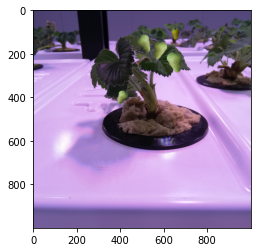

In [ ]:
plt.imshow(img)

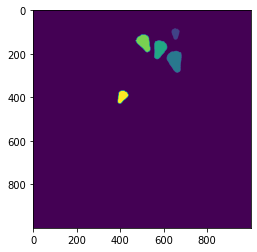

In [ ]:
plt.imshow(mask)

# Train Mask RCNN beagle based

In [ ]:
dataset_dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/'
weights_dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/MRCNN/mask_rcnn_coco.h5'
script_dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/fine-tune-MaskRcnn/beagle.py'

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

In [ ]:
ROOT_DIR = os.path.abspath('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/')
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs_Oganes")
COCO_WEIGHTS_PATH = weights_dir

sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import model as modellib,utils

# Code for training

In [ ]:
!ls 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/train/img/' | wc -l

1360


In [ ]:
from tqdm import tqdm
!ls 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/test/img/dataset_part4_images/' | wc -l

0


In [ ]:
'''
dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/test/img/'
for index_file,filename in tqdm(enumerate(os.listdir(os.path.join(dir,'dataset_part4_images')))):


  place_from=dir+'dataset_part4_images/'+filename
  place_to=dir+filename
  print(filename,'mv {} {}'.format(place_from,place_to))
  os.system('mv "{}" "{}"'.format(place_from,place_to))
  #!mv place_from place_to
'''

0it [00:00, ?it/s]


In [ ]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "strawberry"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + beagle

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load the beagle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("strawberry", 1, "strawberry")

        # Train or validation dataset?
        assert subset in ["train", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        for index_file,filename in tqdm(enumerate(os.listdir(os.path.join(dataset_dir,'img')))):
            image_path = os.path.join(dataset_dir, 'img' ,filename)
            mask_path= os.path.join(dataset_dir, 'label',filename)
            image = skimage.io.imread(image_path)
            #image = skimage.io.imread(image_path,plugin='matplotlib')
            #image=np.asarray(Image.open(image_path))
            #mask=np.ones_like(image)
            #mask= skimage.io.imread(mask_path)
            mask=np.load(mask_path)
            height, width = image.shape[:2]
            self.add_image(
                "strawberry",  ## for a single class just add the name here
                image_id=filename,  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=mask)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a beagle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "strawberry":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask_image = info["polygons"]
        detected_ids=np.unique(mask_image)[1:]

        mask = np.zeros([info["height"], info["width"], len(detected_ids)],
                        dtype=np.uint8)

        for i,id in enumerate(detected_ids):
            mask[:,:,i][mask_image==id]=1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "strawberry":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


from tensorflow.keras.callbacks import LambdaCallback
Checkpoints_Folder='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Checkpoints/'
def on_epoch_end(epoch=0, logs=''):
    Model_folder=Checkpoints_Folder+'/Model_epoch_{}.h5'.format(epoch)
    model.save_weights(Model_folder)

checkpoint_callback=LambdaCallback(on_epoch_end=on_epoch_end)

def train(model,config):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(dataset_dir, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(dataset_dir, "test")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')
    



def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)




In [ ]:
    command='train'

    if command == "train":
        config = CustomConfig()
    else:
        class InferenceConfig(CustomConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

    weights_path = COCO_WEIGHTS_PATH

    # Load weights
    print("Loading weights ", weights_path)
    
    # Exclude the last layers because they require a matching
    # number of classes
    model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

    # Train or evaluate
    if command == "train":
        train(model,config)



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

1356it [15:18,  1.48it/s]
321it [03:45,  1.43it/s]


Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs_Oganes/strawberry20211121T0216/mask_rcnn_strawberry_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 1:42:46 - batch: 0.0000e+00 - size: 1.0000 - loss: 2.5840 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 0.1546 - mrcnn_class_loss: 1.0712 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.6578

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 3:45 - batch: 0.5000 - size: 1.0000 - loss: 2.1706 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.8358 - mrcnn_bbox_loss: 0.5413 - mrcnn_mask_loss: 0.5524       

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:51 - batch: 1.0000 - size: 1.0000 - loss: 2.2478 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.6712 - mrcnn_bbox_loss: 0.5807 - mrcnn_mask_loss: 0.4669

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 2:31 - batch: 1.5000 - size: 1.0000 - loss: 2.1471 - rpn_class_loss: 0.1188 - rpn_bbox_loss: 0.4579 - mrcnn_class_loss: 0.5810 - mrcnn_bbox_loss: 0.5804 - mrcnn_mask_loss: 0.4089

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:21 - batch: 2.0000 - size: 1.0000 - loss: 2.0351 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 0.4996 - mrcnn_class_loss: 0.4901 - mrcnn_bbox_loss: 0.5542 - mrcnn_mask_loss: 0.3602

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 2:14 - batch: 2.5000 - size: 1.0000 - loss: 1.8872 - rpn_class_loss: 0.1319 - rpn_bbox_loss: 0.4667 - mrcnn_class_loss: 0.4274 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.3168

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:09 - batch: 3.0000 - size: 1.0000 - loss: 1.7551 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.3855 - mrcnn_bbox_loss: 0.5585 - mrcnn_mask_loss: 0.2882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:06 - batch: 3.5000 - size: 1.0000 - loss: 1.6332 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.3658 - mrcnn_class_loss: 0.3605 - mrcnn_bbox_loss: 0.5405 - mrcnn_mask_loss: 0.2657

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:02 - batch: 4.0000 - size: 1.0000 - loss: 1.5849 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 0.3424 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.2520

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 2:00 - batch: 4.5000 - size: 1.0000 - loss: 1.5284 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 0.3213 - mrcnn_class_loss: 0.3257 - mrcnn_bbox_loss: 0.5554 - mrcnn_mask_loss: 0.2394

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 1.4854 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 0.3016 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.5564 - mrcnn_mask_loss: 0.2254

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:55 - batch: 5.5000 - size: 1.0000 - loss: 1.4227 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.2869 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.2130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:53 - batch: 6.0000 - size: 1.0000 - loss: 1.4280 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.2900 - mrcnn_class_loss: 0.3080 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.2169

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:51 - batch: 6.5000 - size: 1.0000 - loss: 1.4329 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.2909 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.5434 - mrcnn_mask_loss: 0.2207

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:49 - batch: 7.0000 - size: 1.0000 - loss: 1.4357 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.2908 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.5558 - mrcnn_mask_loss: 0.2153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:48 - batch: 7.5000 - size: 1.0000 - loss: 1.4157 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.2864 - mrcnn_class_loss: 0.2999 - mrcnn_bbox_loss: 0.5548 - mrcnn_mask_loss: 0.2109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:46 - batch: 8.0000 - size: 1.0000 - loss: 1.3902 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.2773 - mrcnn_class_loss: 0.2911 - mrcnn_bbox_loss: 0.5560 - mrcnn_mask_loss: 0.2040

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:44 - batch: 8.5000 - size: 1.0000 - loss: 1.3585 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.5488 - mrcnn_mask_loss: 0.1977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:43 - batch: 9.0000 - size: 1.0000 - loss: 1.3435 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.5387 - mrcnn_mask_loss: 0.1955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:41 - batch: 9.5000 - size: 1.0000 - loss: 1.3258 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.2784 - mrcnn_bbox_loss: 0.5279 - mrcnn_mask_loss: 0.1929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:40 - batch: 10.0000 - size: 1.0000 - loss: 1.3059 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.5191 - mrcnn_mask_loss: 0.1885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:38 - batch: 10.5000 - size: 1.0000 - loss: 1.2763 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 0.2662 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.5069 - mrcnn_mask_loss: 0.1840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:37 - batch: 11.0000 - size: 1.0000 - loss: 1.2541 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.1801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:35 - batch: 11.5000 - size: 1.0000 - loss: 1.2317 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.2647 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.4867 - mrcnn_mask_loss: 0.1763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:34 - batch: 12.0000 - size: 1.0000 - loss: 1.2296 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.4864 - mrcnn_mask_loss: 0.1746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:33 - batch: 12.5000 - size: 1.0000 - loss: 1.2155 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.2534 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.1730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:31 - batch: 13.0000 - size: 1.0000 - loss: 1.1934 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.2493 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.4754 - mrcnn_mask_loss: 0.1694

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:30 - batch: 13.5000 - size: 1.0000 - loss: 1.1680 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.2448 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.4660 - mrcnn_mask_loss: 0.1659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:29 - batch: 14.0000 - size: 1.0000 - loss: 1.1456 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.2422 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.4562 - mrcnn_mask_loss: 0.1624

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:27 - batch: 14.5000 - size: 1.0000 - loss: 1.1259 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.2396 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.1591

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:26 - batch: 15.0000 - size: 1.0000 - loss: 1.1135 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.2358 - mrcnn_bbox_loss: 0.4430 - mrcnn_mask_loss: 0.1566

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:25 - batch: 15.5000 - size: 1.0000 - loss: 1.0960 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.2309 - mrcnn_bbox_loss: 0.4373 - mrcnn_mask_loss: 0.1541

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:23 - batch: 16.0000 - size: 1.0000 - loss: 1.0898 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.4350 - mrcnn_mask_loss: 0.1527

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:22 - batch: 16.5000 - size: 1.0000 - loss: 1.0816 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.1510

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:21 - batch: 17.0000 - size: 1.0000 - loss: 1.0704 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.2310 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.1492

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:19 - batch: 17.5000 - size: 1.0000 - loss: 1.0556 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.4186 - mrcnn_mask_loss: 0.1478

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:18 - batch: 18.0000 - size: 1.0000 - loss: 1.0586 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.4180 - mrcnn_mask_loss: 0.1530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:17 - batch: 18.5000 - size: 1.0000 - loss: 1.0599 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.1569

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:16 - batch: 19.0000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.1558

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:14 - batch: 19.5000 - size: 1.0000 - loss: 1.0433 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.1551

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:13 - batch: 20.0000 - size: 1.0000 - loss: 1.0325 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.1560

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:12 - batch: 20.5000 - size: 1.0000 - loss: 1.0183 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.1552

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:10 - batch: 21.0000 - size: 1.0000 - loss: 1.0064 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.1538

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:09 - batch: 21.5000 - size: 1.0000 - loss: 0.9928 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.1525

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:08 - batch: 22.0000 - size: 1.0000 - loss: 0.9944 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.3899 - mrcnn_mask_loss: 0.1567

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:07 - batch: 22.5000 - size: 1.0000 - loss: 0.9916 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.2028 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.1595

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:05 - batch: 23.0000 - size: 1.0000 - loss: 0.9806 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.2006 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.1577

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:04 - batch: 23.5000 - size: 1.0000 - loss: 0.9700 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.1559

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:03 - batch: 24.0000 - size: 1.0000 - loss: 0.9615 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.1978 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.1549

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:02 - batch: 24.5000 - size: 1.0000 - loss: 0.9532 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.1968 - mrcnn_bbox_loss: 0.3744 - mrcnn_mask_loss: 0.1538

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:00 - batch: 25.0000 - size: 1.0000 - loss: 0.9453 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.1957 - mrcnn_bbox_loss: 0.3710 - mrcnn_mask_loss: 0.1530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 59s - batch: 25.5000 - size: 1.0000 - loss: 0.9370 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.3665 - mrcnn_mask_loss: 0.1523 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 58s - batch: 26.0000 - size: 1.0000 - loss: 0.9329 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.1941 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.1515

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 57s - batch: 26.5000 - size: 1.0000 - loss: 0.9273 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.3593 - mrcnn_mask_loss: 0.1507

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 55s - batch: 27.0000 - size: 1.0000 - loss: 0.9198 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.1495

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 54s - batch: 27.5000 - size: 1.0000 - loss: 0.9116 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.1890 - mrcnn_bbox_loss: 0.3528 - mrcnn_mask_loss: 0.1483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 53s - batch: 28.0000 - size: 1.0000 - loss: 0.9034 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.1865 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.1475

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.1850 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.1468

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 50s - batch: 29.0000 - size: 1.0000 - loss: 0.8981 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.1852 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.1473

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 49s - batch: 29.5000 - size: 1.0000 - loss: 0.8990 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.1472

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 48s - batch: 30.0000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1895 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.1458

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.1827 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.1444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 45s - batch: 31.0000 - size: 1.0000 - loss: 0.8795 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.1867 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.3408 - mrcnn_mask_loss: 0.1432

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 44s - batch: 31.5000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.1847 - mrcnn_class_loss: 0.1805 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.1420

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.8809 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1889 - mrcnn_class_loss: 0.1806 - mrcnn_bbox_loss: 0.3375 - mrcnn_mask_loss: 0.1474

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.1816 - mrcnn_bbox_loss: 0.3370 - mrcnn_mask_loss: 0.1523

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 40s - batch: 33.0000 - size: 1.0000 - loss: 0.8848 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.1919 - mrcnn_class_loss: 0.1801 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.1510

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 39s - batch: 33.5000 - size: 1.0000 - loss: 0.8779 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.1786 - mrcnn_bbox_loss: 0.3332 - mrcnn_mask_loss: 0.1499

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.8717 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.1893 - mrcnn_class_loss: 0.1778 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.1490

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.8650 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 0.1482

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 35s - batch: 35.0000 - size: 1.0000 - loss: 0.8619 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1877 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.3258 - mrcnn_mask_loss: 0.1476

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 34s - batch: 35.5000 - size: 1.0000 - loss: 0.8583 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.1470

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.8532 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1864 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.1461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.8472 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.1852 - mrcnn_class_loss: 0.1735 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.1453

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 30s - batch: 37.0000 - size: 1.0000 - loss: 0.8419 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.1727 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.1446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 29s - batch: 37.5000 - size: 1.0000 - loss: 0.8363 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.1828 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.1438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.8329 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.1434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.8288 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.1816 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.1428

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 25s - batch: 39.0000 - size: 1.0000 - loss: 0.8248 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.1420

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 24s - batch: 39.5000 - size: 1.0000 - loss: 0.8211 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.1806 - mrcnn_class_loss: 0.1694 - mrcnn_bbox_loss: 0.3050 - mrcnn_mask_loss: 0.1413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.8173 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.1798 - mrcnn_class_loss: 0.1680 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.1417

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.8128 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.1417

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.8088 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.1408

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.8042 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.1763 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.1400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.7985 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.1393

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.7930 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.1637 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.1386

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.7890 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1719 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.1383

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.7848 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.1379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.7808 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.1372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.7762 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.1598 - mrcnn_bbox_loss: 0.2873 - mrcnn_mask_loss: 0.1366

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.7765 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.1380

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.7761 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.1387 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.7736 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1672 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.2838 - mrcnn_mask_loss: 0.1385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.7698 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.1382

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.7675 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.1379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.7645 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1657 - mrcnn_class_loss: 0.1606 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.1375

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.7595 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1646 - mrcnn_class_loss: 0.1594 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.1371

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.7548 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1636 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.1367

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.7505 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1628 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.1359

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.7455 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.1352WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied aut

100/100 [==============================] - 274s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.7455 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.1352 - val_loss: 0.4031 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.1007 - val_mrcnn_class_loss: 0.1022 - val_mrcnn_bbox_loss: 0.0920 - val_mrcnn_mask_loss: 0.0916
Epoch 2/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 2:16 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.5579 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2515 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.0804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 2:01 - batch: 0.5000 - size: 1.0000 - loss: 0.5657 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.0984    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:58 - batch: 1.0000 - size: 1.0000 - loss: 0.4927 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.0857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:57 - batch: 1.5000 - size: 1.0000 - loss: 0.4436 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1438 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.0791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:56 - batch: 2.0000 - size: 1.0000 - loss: 0.5035 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1183

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:54 - batch: 2.5000 - size: 1.0000 - loss: 0.5235 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:53 - batch: 3.0000 - size: 1.0000 - loss: 0.4894 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1273

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:52 - batch: 3.5000 - size: 1.0000 - loss: 0.4642 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1195

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:51 - batch: 4.0000 - size: 1.0000 - loss: 0.4546 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.1159

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:49 - batch: 4.5000 - size: 1.0000 - loss: 0.4510 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1133

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:48 - batch: 5.0000 - size: 1.0000 - loss: 0.4446 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1092

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:47 - batch: 5.5000 - size: 1.0000 - loss: 0.4340 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1059

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:46 - batch: 6.0000 - size: 1.0000 - loss: 0.4294 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1044

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:45 - batch: 6.5000 - size: 1.0000 - loss: 0.4254 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1030

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:43 - batch: 7.0000 - size: 1.0000 - loss: 0.4340 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:42 - batch: 7.5000 - size: 1.0000 - loss: 0.4373 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.0997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:41 - batch: 8.0000 - size: 1.0000 - loss: 0.4310 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.0995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:40 - batch: 8.5000 - size: 1.0000 - loss: 0.4238 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1002

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:39 - batch: 9.0000 - size: 1.0000 - loss: 0.4167 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.0982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:37 - batch: 9.5000 - size: 1.0000 - loss: 0.4109 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.0964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:36 - batch: 10.0000 - size: 1.0000 - loss: 0.4074 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.0947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:35 - batch: 10.5000 - size: 1.0000 - loss: 0.4004 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.0932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:33 - batch: 11.0000 - size: 1.0000 - loss: 0.4120 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.0971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:32 - batch: 11.5000 - size: 1.0000 - loss: 0.4164 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.0996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:31 - batch: 12.0000 - size: 1.0000 - loss: 0.4147 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.0987

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:30 - batch: 12.5000 - size: 1.0000 - loss: 0.4120 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.0978

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:28 - batch: 13.0000 - size: 1.0000 - loss: 0.4080 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.0967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:27 - batch: 13.5000 - size: 1.0000 - loss: 0.4015 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.0957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:26 - batch: 14.0000 - size: 1.0000 - loss: 0.3983 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.0943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:25 - batch: 14.5000 - size: 1.0000 - loss: 0.3942 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.0929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:24 - batch: 15.0000 - size: 1.0000 - loss: 0.3942 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.0925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:22 - batch: 15.5000 - size: 1.0000 - loss: 0.3919 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.0921

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:21 - batch: 16.0000 - size: 1.0000 - loss: 0.4194 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.0973

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:20 - batch: 16.5000 - size: 1.0000 - loss: 0.4423 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.1029

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:19 - batch: 17.0000 - size: 1.0000 - loss: 0.4446 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1020

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:18 - batch: 17.5000 - size: 1.0000 - loss: 0.4497 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:16 - batch: 18.0000 - size: 1.0000 - loss: 0.4467 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:15 - batch: 18.5000 - size: 1.0000 - loss: 0.4451 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.0996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:14 - batch: 19.0000 - size: 1.0000 - loss: 0.4419 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.0988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:13 - batch: 19.5000 - size: 1.0000 - loss: 0.4387 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.0980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:12 - batch: 20.0000 - size: 1.0000 - loss: 0.4345 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.0970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:10 - batch: 20.5000 - size: 1.0000 - loss: 0.4300 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.0961

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:09 - batch: 21.0000 - size: 1.0000 - loss: 0.4275 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.0952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:08 - batch: 21.5000 - size: 1.0000 - loss: 0.4241 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1022 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.0944

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:07 - batch: 22.0000 - size: 1.0000 - loss: 0.4351 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1045

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:05 - batch: 22.5000 - size: 1.0000 - loss: 0.4452 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1138

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:04 - batch: 23.0000 - size: 1.0000 - loss: 0.4429 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:03 - batch: 23.5000 - size: 1.0000 - loss: 0.4399 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:02 - batch: 24.0000 - size: 1.0000 - loss: 0.4447 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:01 - batch: 24.5000 - size: 1.0000 - loss: 0.4514 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1141

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 59s - batch: 25.0000 - size: 1.0000 - loss: 0.4492 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1139 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 58s - batch: 25.5000 - size: 1.0000 - loss: 0.4468 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1137

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 57s - batch: 26.0000 - size: 1.0000 - loss: 0.4446 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1140

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 56s - batch: 26.5000 - size: 1.0000 - loss: 0.4422 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.1141

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 55s - batch: 27.0000 - size: 1.0000 - loss: 0.4390 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.1134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 53s - batch: 27.5000 - size: 1.0000 - loss: 0.4349 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.1125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 52s - batch: 28.0000 - size: 1.0000 - loss: 0.4317 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1120

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 51s - batch: 28.5000 - size: 1.0000 - loss: 0.4282 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1114

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 50s - batch: 29.0000 - size: 1.0000 - loss: 0.4381 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1117

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 48s - batch: 29.5000 - size: 1.0000 - loss: 0.4443 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 47s - batch: 30.0000 - size: 1.0000 - loss: 0.4490 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 46s - batch: 30.5000 - size: 1.0000 - loss: 0.4511 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 45s - batch: 31.0000 - size: 1.0000 - loss: 0.4515 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 44s - batch: 31.5000 - size: 1.0000 - loss: 0.4522 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 42s - batch: 32.0000 - size: 1.0000 - loss: 0.4533 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1124

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 41s - batch: 32.5000 - size: 1.0000 - loss: 0.4530 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1127

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 40s - batch: 33.0000 - size: 1.0000 - loss: 0.4505 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1120

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 39s - batch: 33.5000 - size: 1.0000 - loss: 0.4480 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.1113

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 37s - batch: 34.0000 - size: 1.0000 - loss: 0.4538 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1147

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 36s - batch: 34.5000 - size: 1.0000 - loss: 0.4577 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1172

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 35s - batch: 35.0000 - size: 1.0000 - loss: 0.4571 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 34s - batch: 35.5000 - size: 1.0000 - loss: 0.4559 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1158

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.4551 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 31s - batch: 36.5000 - size: 1.0000 - loss: 0.4539 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1149

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 30s - batch: 37.0000 - size: 1.0000 - loss: 0.4525 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1145

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 29s - batch: 37.5000 - size: 1.0000 - loss: 0.4505 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1139

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.4497 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1137

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 26s - batch: 38.5000 - size: 1.0000 - loss: 0.4485 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 25s - batch: 39.0000 - size: 1.0000 - loss: 0.4474 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 24s - batch: 39.5000 - size: 1.0000 - loss: 0.4461 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.4450 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.4433 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1020 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1114

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 20s - batch: 41.0000 - size: 1.0000 - loss: 0.4418 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1108

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.4398 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.4403 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1108

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.4415 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 15s - batch: 43.0000 - size: 1.0000 - loss: 0.4402 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.4381 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.4445 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1098

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.4493 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.4476 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1089

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.4457 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1084 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.4442 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1081

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.4429 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1078

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.4412 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1075

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.4396 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.4370 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1067

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.4344 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1062

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.4351 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1069

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.4346 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1070WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 165s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.4346 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1070 - val_loss: 0.3623 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.0901 - val_mrcnn_class_loss: 0.0914 - val_mrcnn_bbox_loss: 0.0797 - val_mrcnn_mask_loss: 0.0878
Epoch 3/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:20 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.6765 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1204

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:08 - batch: 0.5000 - size: 1.0000 - loss: 0.5882 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.1874 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1152    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:03 - batch: 1.0000 - size: 1.0000 - loss: 0.5740 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1649 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:01 - batch: 1.5000 - size: 1.0000 - loss: 0.5407 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:02 - batch: 2.0000 - size: 1.0000 - loss: 0.4981 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1617

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:02 - batch: 2.5000 - size: 1.0000 - loss: 0.4662 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:03 - batch: 3.0000 - size: 1.0000 - loss: 0.4914 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1405

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:01 - batch: 3.5000 - size: 1.0000 - loss: 0.5011 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1388

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.4819 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1323

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:58 - batch: 4.5000 - size: 1.0000 - loss: 0.4675 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1275

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.5121 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1396

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:55 - batch: 5.5000 - size: 1.0000 - loss: 0.5382 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.6213 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1801 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1846

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:53 - batch: 6.5000 - size: 1.0000 - loss: 0.6739 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1880 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2129

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 0.6496 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2060

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.6286 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2016

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 0.6915 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.2051

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:46 - batch: 8.5000 - size: 1.0000 - loss: 0.7362 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:45 - batch: 9.0000 - size: 1.0000 - loss: 0.7331 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.2125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:43 - batch: 9.5000 - size: 1.0000 - loss: 0.7216 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2131

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:42 - batch: 10.0000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2142

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:40 - batch: 10.5000 - size: 1.0000 - loss: 0.7318 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.2150

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:39 - batch: 11.0000 - size: 1.0000 - loss: 0.7142 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:37 - batch: 11.5000 - size: 1.0000 - loss: 0.6980 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.2046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - batch: 12.0000 - size: 1.0000 - loss: 0.6850 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2009

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:34 - batch: 12.5000 - size: 1.0000 - loss: 0.6716 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:33 - batch: 13.0000 - size: 1.0000 - loss: 0.6610 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1947 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.1935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:31 - batch: 13.5000 - size: 1.0000 - loss: 0.6500 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.1901

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:30 - batch: 14.0000 - size: 1.0000 - loss: 0.6384 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1868 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1866

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - batch: 14.5000 - size: 1.0000 - loss: 0.6279 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1830 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.1835

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:27 - batch: 15.0000 - size: 1.0000 - loss: 0.6211 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1828

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:26 - batch: 15.5000 - size: 1.0000 - loss: 0.6121 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - batch: 16.0000 - size: 1.0000 - loss: 0.6146 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:23 - batch: 16.5000 - size: 1.0000 - loss: 0.6153 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1888

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:22 - batch: 17.0000 - size: 1.0000 - loss: 0.6059 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1678 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 0.5967 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1828

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:19 - batch: 18.0000 - size: 1.0000 - loss: 0.5898 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1628 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:18 - batch: 18.5000 - size: 1.0000 - loss: 0.5824 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1609 - mrcnn_class_loss: 0.1239 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 0.5861 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1592 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:15 - batch: 19.5000 - size: 1.0000 - loss: 0.5877 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 0.5893 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.5907 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1555 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:11 - batch: 21.0000 - size: 1.0000 - loss: 0.5836 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1538 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.1791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.5774 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1519 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:09 - batch: 22.0000 - size: 1.0000 - loss: 0.5797 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.5800 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1800

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:06 - batch: 23.0000 - size: 1.0000 - loss: 0.5842 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.5862 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.5864 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:02 - batch: 24.5000 - size: 1.0000 - loss: 0.5871 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.5855 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.1820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.5850 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.5799 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1790 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 57s - batch: 26.5000 - size: 1.0000 - loss: 0.5744 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.5705 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.5661 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 53s - batch: 28.0000 - size: 1.0000 - loss: 0.5609 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.5552 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.1697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.5494 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.1681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.5439 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1664

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 48s - batch: 30.0000 - size: 1.0000 - loss: 0.5425 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1652

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.5397 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1639

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.5411 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1631

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.5414 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1622

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.5380 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1610

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.5344 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1600

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.5302 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1585

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 39s - batch: 33.5000 - size: 1.0000 - loss: 0.5261 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1572

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.5262 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1561

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.5269 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1550

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.5304 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1558

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 34s - batch: 35.5000 - size: 1.0000 - loss: 0.5325 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1563

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.5285 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1552

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.5245 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1541

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.5228 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1536

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 29s - batch: 37.5000 - size: 1.0000 - loss: 0.5205 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.5170 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1518

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.5134 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1506

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.5099 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1494

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 24s - batch: 39.5000 - size: 1.0000 - loss: 0.5067 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1482

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.5038 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1472

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.5005 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1462

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.4978 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1453

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.4955 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.4962 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.4964 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.4947 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.4926 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.4893 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.1162 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1421

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.4860 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1411

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.4837 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1409

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.4819 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1407 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.4810 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1399

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.4798 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1191 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1390

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.4766 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1381

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.4745 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.4720 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1366

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.4697 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1360

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.4703 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1356

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.4717 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1354WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 167s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.4717 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1354 - val_loss: 0.3470 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.1072 - val_mrcnn_class_loss: 0.0745 - val_mrcnn_bbox_loss: 0.0695 - val_mrcnn_mask_loss: 0.0873
Epoch 4/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:19 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.1830 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0553

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:07 - batch: 0.5000 - size: 1.0000 - loss: 0.1918 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.0550    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:03 - batch: 1.0000 - size: 1.0000 - loss: 0.2679 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:02 - batch: 1.5000 - size: 1.0000 - loss: 0.2877 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:01 - batch: 2.0000 - size: 1.0000 - loss: 0.2692 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 1:59 - batch: 2.5000 - size: 1.0000 - loss: 0.2642 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.0767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 1:58 - batch: 3.0000 - size: 1.0000 - loss: 0.2672 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.0758

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 1:57 - batch: 3.5000 - size: 1.0000 - loss: 0.2670 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:56 - batch: 4.0000 - size: 1.0000 - loss: 0.3018 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.0791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:55 - batch: 4.5000 - size: 1.0000 - loss: 0.3220 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:55 - batch: 5.0000 - size: 1.0000 - loss: 0.3129 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:53 - batch: 5.5000 - size: 1.0000 - loss: 0.3069 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.0788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:52 - batch: 6.0000 - size: 1.0000 - loss: 0.3088 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.0787

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:51 - batch: 6.5000 - size: 1.0000 - loss: 0.3076 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:49 - batch: 7.0000 - size: 1.0000 - loss: 0.3263 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.0887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:48 - batch: 7.5000 - size: 1.0000 - loss: 0.3449 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.0970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:46 - batch: 8.0000 - size: 1.0000 - loss: 0.3439 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.0958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:45 - batch: 8.5000 - size: 1.0000 - loss: 0.3413 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.0945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:43 - batch: 9.0000 - size: 1.0000 - loss: 0.3350 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.0924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:42 - batch: 9.5000 - size: 1.0000 - loss: 0.3291 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.0906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:40 - batch: 10.0000 - size: 1.0000 - loss: 0.3313 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.0896

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:39 - batch: 10.5000 - size: 1.0000 - loss: 0.3326 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:38 - batch: 11.0000 - size: 1.0000 - loss: 0.3323 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:36 - batch: 11.5000 - size: 1.0000 - loss: 0.3300 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.0868

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:35 - batch: 12.0000 - size: 1.0000 - loss: 0.3303 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.0859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:33 - batch: 12.5000 - size: 1.0000 - loss: 0.3299 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.0852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:32 - batch: 13.0000 - size: 1.0000 - loss: 0.3287 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.0849

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:31 - batch: 13.5000 - size: 1.0000 - loss: 0.3265 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:29 - batch: 14.0000 - size: 1.0000 - loss: 0.4848 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.0837

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:28 - batch: 14.5000 - size: 1.0000 - loss: 0.6155 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.3195 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.0830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:27 - batch: 15.0000 - size: 1.0000 - loss: 0.6026 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.3112 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.0825

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:25 - batch: 15.5000 - size: 1.0000 - loss: 0.5901 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:24 - batch: 16.0000 - size: 1.0000 - loss: 0.5820 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:23 - batch: 16.5000 - size: 1.0000 - loss: 0.5767 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.2904 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:21 - batch: 17.0000 - size: 1.0000 - loss: 0.5676 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.2845 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.0808

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:20 - batch: 17.5000 - size: 1.0000 - loss: 0.5578 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.0804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:19 - batch: 18.0000 - size: 1.0000 - loss: 0.5508 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:17 - batch: 18.5000 - size: 1.0000 - loss: 0.5428 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:16 - batch: 19.0000 - size: 1.0000 - loss: 0.5440 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.2635 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.0832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:15 - batch: 19.5000 - size: 1.0000 - loss: 0.5433 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.0849

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 0.5398 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.0847

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:12 - batch: 20.5000 - size: 1.0000 - loss: 0.5362 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:11 - batch: 21.0000 - size: 1.0000 - loss: 0.5345 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.0849

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.5308 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.2457 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.0851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:08 - batch: 22.0000 - size: 1.0000 - loss: 0.5260 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.2414 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.0852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:07 - batch: 22.5000 - size: 1.0000 - loss: 0.5214 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.0853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:06 - batch: 23.0000 - size: 1.0000 - loss: 0.5148 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.2332 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.0849

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.5091 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:03 - batch: 24.0000 - size: 1.0000 - loss: 0.5040 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:02 - batch: 24.5000 - size: 1.0000 - loss: 0.4985 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.0835

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.4936 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.4886 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 58s - batch: 26.0000 - size: 1.0000 - loss: 0.4830 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.0817 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 57s - batch: 26.5000 - size: 1.0000 - loss: 0.4779 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.4735 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.4686 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 53s - batch: 28.0000 - size: 1.0000 - loss: 0.4668 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.0806

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.4642 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.4601 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.0808

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 49s - batch: 29.5000 - size: 1.0000 - loss: 0.4560 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.0804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 48s - batch: 30.0000 - size: 1.0000 - loss: 0.4509 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.4459 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1879 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.4718 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 44s - batch: 31.5000 - size: 1.0000 - loss: 0.4899 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0800

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.4854 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2293 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.4810 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.0794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.4785 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 39s - batch: 33.5000 - size: 1.0000 - loss: 0.4765 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.0800

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.4808 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.4825 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.4796 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 34s - batch: 35.5000 - size: 1.0000 - loss: 0.4761 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.4733 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.4705 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.4727 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.0842

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 29s - batch: 37.5000 - size: 1.0000 - loss: 0.4734 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.4727 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.0859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.4710 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.4719 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.2110 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.0863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 24s - batch: 39.5000 - size: 1.0000 - loss: 0.4734 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.0868

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.4713 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.0867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.4686 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2076 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.0865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.4668 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2066 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.0862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.4651 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.4638 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.4626 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.4641 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.0871

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.4650 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.2027 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.4627 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.0876

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.4605 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.0873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.4590 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.4569 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.0874 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.4554 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.4541 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1943 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.0876

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.4574 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.4610 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.0885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.4589 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.0883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.4571 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.0881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.4553 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1884 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.4530 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.0877WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 167s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.4530 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.0877 - val_loss: 0.3863 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.1256 - val_mrcnn_class_loss: 0.1033 - val_mrcnn_bbox_loss: 0.0564 - val_mrcnn_mask_loss: 0.0891
Epoch 5/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:17 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.4453 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1158

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:05 - batch: 0.5000 - size: 1.0000 - loss: 0.4258 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1101    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:05 - batch: 1.0000 - size: 1.0000 - loss: 0.3918 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.0998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.3705 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:08 - batch: 2.0000 - size: 1.0000 - loss: 0.3395 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.0882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:07 - batch: 2.5000 - size: 1.0000 - loss: 0.3210 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.0833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:04 - batch: 3.0000 - size: 1.0000 - loss: 0.3318 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:03 - batch: 3.5000 - size: 1.0000 - loss: 0.3305 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.3222 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:59 - batch: 4.5000 - size: 1.0000 - loss: 0.3146 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.3116 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:55 - batch: 5.5000 - size: 1.0000 - loss: 0.3052 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.3073 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:52 - batch: 6.5000 - size: 1.0000 - loss: 0.3070 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 0.3222 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.3295 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 0.3940 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:47 - batch: 8.5000 - size: 1.0000 - loss: 0.4366 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1345

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:45 - batch: 9.0000 - size: 1.0000 - loss: 0.4280 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1305

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:44 - batch: 9.5000 - size: 1.0000 - loss: 0.4192 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1063 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1269

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:42 - batch: 10.0000 - size: 1.0000 - loss: 0.4107 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1245

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:40 - batch: 10.5000 - size: 1.0000 - loss: 0.4069 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1226

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:39 - batch: 11.0000 - size: 1.0000 - loss: 0.3983 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1203

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:38 - batch: 11.5000 - size: 1.0000 - loss: 0.3899 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1182

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - batch: 12.0000 - size: 1.0000 - loss: 0.3856 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1167

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:35 - batch: 12.5000 - size: 1.0000 - loss: 0.3811 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1155

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:33 - batch: 13.0000 - size: 1.0000 - loss: 0.3776 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1139

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - batch: 13.5000 - size: 1.0000 - loss: 0.3743 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1127

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:30 - batch: 14.0000 - size: 1.0000 - loss: 0.3748 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1148

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - batch: 14.5000 - size: 1.0000 - loss: 0.3756 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1169

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - batch: 15.0000 - size: 1.0000 - loss: 0.3756 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1168

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:26 - batch: 15.5000 - size: 1.0000 - loss: 0.3756 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - batch: 16.0000 - size: 1.0000 - loss: 0.3700 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1149

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - batch: 16.5000 - size: 1.0000 - loss: 0.3641 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1131

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:22 - batch: 17.0000 - size: 1.0000 - loss: 0.3613 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1114

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 0.3579 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - batch: 18.0000 - size: 1.0000 - loss: 0.3967 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1191

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:18 - batch: 18.5000 - size: 1.0000 - loss: 0.4264 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1288

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 0.4206 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.4155 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1258

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 0.4156 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1203 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1250

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.4166 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1245

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.4134 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.4096 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:09 - batch: 22.0000 - size: 1.0000 - loss: 0.4132 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1200 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1216

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.4160 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1210

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.4136 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.4126 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.4129 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1187

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.4126 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1183

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.4106 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1178

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.4079 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1173

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.4058 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1169 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.4036 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.4016 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1158

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.3990 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1150

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.4014 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1162

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.4035 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1171

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.4010 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1161

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.3985 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1151

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.3984 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.3976 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1154

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.3962 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1160

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.3947 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1166

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.3951 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1166

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.3958 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1166

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.3937 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1159

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.3916 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.3907 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1151

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.3898 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1147

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.3871 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1138

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.3853 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.3955 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1137

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.4053 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1150

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.4037 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1143

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.4014 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1136

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.3998 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1133

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.3989 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.4039 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1161

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.4072 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1183

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.4071 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1180

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.4067 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1176

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.4053 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1170

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.4031 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1164

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.4006 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1157

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3981 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1150

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.4030 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1178

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.4072 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1202

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.4053 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1196

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.4034 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1190

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.4026 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1185

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.4016 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1181 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.4002 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1178

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3988 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1175

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3982 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1169

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.3976 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3954 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1160

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3933 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1155

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3924 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3912 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1150WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 168s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3912 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1150 - val_loss: 0.2958 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.1010 - val_mrcnn_class_loss: 0.0436 - val_mrcnn_bbox_loss: 0.0554 - val_mrcnn_mask_loss: 0.0872
Epoch 6/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:14 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2892 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:06 - batch: 0.5000 - size: 1.0000 - loss: 0.2583 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0654    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:05 - batch: 1.0000 - size: 1.0000 - loss: 0.3309 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.3466 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:02 - batch: 2.0000 - size: 1.0000 - loss: 0.3236 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 1:59 - batch: 2.5000 - size: 1.0000 - loss: 0.3169 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0710

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 1:58 - batch: 3.0000 - size: 1.0000 - loss: 0.3454 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 1:56 - batch: 3.5000 - size: 1.0000 - loss: 0.3594 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1057

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 1:55 - batch: 4.0000 - size: 1.0000 - loss: 0.3502 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.0999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:54 - batch: 4.5000 - size: 1.0000 - loss: 0.3407 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.0952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:53 - batch: 5.0000 - size: 1.0000 - loss: 0.3346 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.0930

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:52 - batch: 5.5000 - size: 1.0000 - loss: 0.3263 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.0910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:50 - batch: 6.0000 - size: 1.0000 - loss: 0.3192 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.0878

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:49 - batch: 6.5000 - size: 1.0000 - loss: 0.3134 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:47 - batch: 7.0000 - size: 1.0000 - loss: 0.3181 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:46 - batch: 7.5000 - size: 1.0000 - loss: 0.3178 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:45 - batch: 8.0000 - size: 1.0000 - loss: 0.3152 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:43 - batch: 8.5000 - size: 1.0000 - loss: 0.3111 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1051 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:42 - batch: 9.0000 - size: 1.0000 - loss: 0.3098 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:41 - batch: 9.5000 - size: 1.0000 - loss: 0.3058 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:40 - batch: 10.0000 - size: 1.0000 - loss: 0.3009 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:38 - batch: 10.5000 - size: 1.0000 - loss: 0.2953 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:37 - batch: 11.0000 - size: 1.0000 - loss: 0.3115 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:35 - batch: 11.5000 - size: 1.0000 - loss: 0.3214 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1034 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:34 - batch: 12.0000 - size: 1.0000 - loss: 0.3254 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1053 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:32 - batch: 12.5000 - size: 1.0000 - loss: 0.3275 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:31 - batch: 13.0000 - size: 1.0000 - loss: 0.3226 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.0833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:30 - batch: 13.5000 - size: 1.0000 - loss: 0.3173 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:28 - batch: 14.0000 - size: 1.0000 - loss: 0.3131 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:27 - batch: 14.5000 - size: 1.0000 - loss: 0.3095 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:26 - batch: 15.0000 - size: 1.0000 - loss: 0.3071 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0805

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:24 - batch: 15.5000 - size: 1.0000 - loss: 0.3034 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:23 - batch: 16.0000 - size: 1.0000 - loss: 0.3090 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.0830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:22 - batch: 16.5000 - size: 1.0000 - loss: 0.3115 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.0853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:20 - batch: 17.0000 - size: 1.0000 - loss: 0.3661 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1451 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:19 - batch: 17.5000 - size: 1.0000 - loss: 0.4061 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:18 - batch: 18.0000 - size: 1.0000 - loss: 0.3986 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.0878

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:16 - batch: 18.5000 - size: 1.0000 - loss: 0.3922 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1755 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.0867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:15 - batch: 19.0000 - size: 1.0000 - loss: 0.3904 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1739 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0860

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:14 - batch: 19.5000 - size: 1.0000 - loss: 0.3876 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1720 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:13 - batch: 20.0000 - size: 1.0000 - loss: 0.3845 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1692 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:11 - batch: 20.5000 - size: 1.0000 - loss: 0.3829 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1666 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:10 - batch: 21.0000 - size: 1.0000 - loss: 0.3774 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:09 - batch: 21.5000 - size: 1.0000 - loss: 0.3727 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1601 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:08 - batch: 22.0000 - size: 1.0000 - loss: 0.3691 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1578 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0846

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:06 - batch: 22.5000 - size: 1.0000 - loss: 0.3653 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:05 - batch: 23.0000 - size: 1.0000 - loss: 0.3650 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:04 - batch: 23.5000 - size: 1.0000 - loss: 0.3647 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0839

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:03 - batch: 24.0000 - size: 1.0000 - loss: 0.3624 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:01 - batch: 24.5000 - size: 1.0000 - loss: 0.3599 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1500 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:00 - batch: 25.0000 - size: 1.0000 - loss: 0.3913 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 59s - batch: 25.5000 - size: 1.0000 - loss: 0.4167 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0837 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 58s - batch: 26.0000 - size: 1.0000 - loss: 0.4140 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 56s - batch: 26.5000 - size: 1.0000 - loss: 0.4107 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1901 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 55s - batch: 27.0000 - size: 1.0000 - loss: 0.4148 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1893 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 54s - batch: 27.5000 - size: 1.0000 - loss: 0.4191 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1885 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 53s - batch: 28.0000 - size: 1.0000 - loss: 0.4163 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.0885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.4139 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.0882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 50s - batch: 29.0000 - size: 1.0000 - loss: 0.4114 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1815 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0877

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 49s - batch: 29.5000 - size: 1.0000 - loss: 0.4084 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1792 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 48s - batch: 30.0000 - size: 1.0000 - loss: 0.4053 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.4021 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0870

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 45s - batch: 31.0000 - size: 1.0000 - loss: 0.4007 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1723 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 44s - batch: 31.5000 - size: 1.0000 - loss: 0.3993 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.3961 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.3934 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1668 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0870

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 40s - batch: 33.0000 - size: 1.0000 - loss: 0.3908 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1649 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 39s - batch: 33.5000 - size: 1.0000 - loss: 0.3878 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1629 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.3851 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.3826 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1591 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 35s - batch: 35.0000 - size: 1.0000 - loss: 0.3799 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 34s - batch: 35.5000 - size: 1.0000 - loss: 0.3773 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0849

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.3759 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0846

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.3744 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1533 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 30s - batch: 37.0000 - size: 1.0000 - loss: 0.3872 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0908

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 29s - batch: 37.5000 - size: 1.0000 - loss: 0.3953 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1538 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.3930 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1526 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.3913 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1515 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.3899 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1504 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 24s - batch: 39.5000 - size: 1.0000 - loss: 0.3892 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.0947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.3892 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1493 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.0945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.3881 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1490 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.3923 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.0963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.3962 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.0984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.3970 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1507 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.0986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3973 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.0987

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.3991 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1502 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.0998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.4009 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1500 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1007

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.4005 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3999 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3977 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.0999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.3956 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.0994 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3941 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.0992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3926 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.0989

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3907 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.0985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.3894 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.0982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3877 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.0978

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3861 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.0975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3852 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.0974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3835 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.0972WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 167s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3835 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.0972 - val_loss: 0.2815 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.0668 - val_mrcnn_class_loss: 0.0714 - val_mrcnn_bbox_loss: 0.0532 - val_mrcnn_mask_loss: 0.0798
Epoch 7/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:23 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.4874 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:14 - batch: 0.5000 - size: 1.0000 - loss: 0.4630 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2093    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:08 - batch: 1.0000 - size: 1.0000 - loss: 0.3658 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0901 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1559

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:08 - batch: 1.5000 - size: 1.0000 - loss: 0.3166 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1291

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:05 - batch: 2.0000 - size: 1.0000 - loss: 0.3276 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1241

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:03 - batch: 2.5000 - size: 1.0000 - loss: 0.3353 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1247

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:01 - batch: 3.0000 - size: 1.0000 - loss: 0.3176 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0507 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1173

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:00 - batch: 3.5000 - size: 1.0000 - loss: 0.3065 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:58 - batch: 4.0000 - size: 1.0000 - loss: 0.3839 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1701

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:58 - batch: 4.5000 - size: 1.0000 - loss: 0.4354 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.2101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.4517 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.2005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:55 - batch: 5.5000 - size: 1.0000 - loss: 0.4548 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1918

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.4496 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:52 - batch: 6.5000 - size: 1.0000 - loss: 0.4448 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 0.4571 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0901 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1861

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:49 - batch: 7.5000 - size: 1.0000 - loss: 0.4677 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 0.4540 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:47 - batch: 8.5000 - size: 1.0000 - loss: 0.4404 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:45 - batch: 9.0000 - size: 1.0000 - loss: 0.4311 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:43 - batch: 9.5000 - size: 1.0000 - loss: 0.4194 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1673

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:42 - batch: 10.0000 - size: 1.0000 - loss: 0.4104 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1621

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:40 - batch: 10.5000 - size: 1.0000 - loss: 0.4013 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1573

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:39 - batch: 11.0000 - size: 1.0000 - loss: 0.3958 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:37 - batch: 11.5000 - size: 1.0000 - loss: 0.3880 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1491

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - batch: 12.0000 - size: 1.0000 - loss: 0.3840 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1486

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:34 - batch: 12.5000 - size: 1.0000 - loss: 0.3807 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1474

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:33 - batch: 13.0000 - size: 1.0000 - loss: 0.3772 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1448

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - batch: 13.5000 - size: 1.0000 - loss: 0.3726 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1422

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:30 - batch: 14.0000 - size: 1.0000 - loss: 0.3666 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1392

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - batch: 14.5000 - size: 1.0000 - loss: 0.3606 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1364

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:27 - batch: 15.0000 - size: 1.0000 - loss: 0.3757 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1458

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:26 - batch: 15.5000 - size: 1.0000 - loss: 0.3867 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1525

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - batch: 16.0000 - size: 1.0000 - loss: 0.3811 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1496

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:23 - batch: 16.5000 - size: 1.0000 - loss: 0.3762 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1468

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:22 - batch: 17.0000 - size: 1.0000 - loss: 0.3726 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1445

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 0.3685 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1425

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:19 - batch: 18.0000 - size: 1.0000 - loss: 0.3727 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:18 - batch: 18.5000 - size: 1.0000 - loss: 0.3748 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 0.3905 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1449

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:15 - batch: 19.5000 - size: 1.0000 - loss: 0.4014 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 0.4088 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.4156 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1451

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:11 - batch: 21.0000 - size: 1.0000 - loss: 0.4099 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1433

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.4033 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1415

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:09 - batch: 22.0000 - size: 1.0000 - loss: 0.4033 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1416

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.4027 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1416

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:06 - batch: 23.0000 - size: 1.0000 - loss: 0.3987 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1399

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.3946 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1384

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.3980 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:02 - batch: 24.5000 - size: 1.0000 - loss: 0.3998 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1361

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.3964 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1345

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.3929 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1331

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.3890 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1318 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 57s - batch: 26.5000 - size: 1.0000 - loss: 0.3851 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1305

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.3866 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1294

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.3877 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1284

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 53s - batch: 28.0000 - size: 1.0000 - loss: 0.3873 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1278

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.3867 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.3827 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1260

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.3785 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1031 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 48s - batch: 30.0000 - size: 1.0000 - loss: 0.3870 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1240

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.3931 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1232

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.3912 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.3886 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1210

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.3863 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1207

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.3838 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1204

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.3814 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.3785 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1183

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.3765 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1175

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.3745 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1134 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1167

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.3722 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1156

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.3693 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1146

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.3668 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1140

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.3650 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1136

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.3630 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.3610 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1121

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.3599 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1114

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.3585 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.3564 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.3541 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.3528 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1091

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.3516 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.3534 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.3551 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1099

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.3535 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3518 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.3504 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1083

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.3490 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1080

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.3474 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1074

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3461 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1024 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1068

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3453 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1024 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.3446 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1022 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1062 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3431 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1056

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3413 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1050

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3397 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.3385 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1041

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3381 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1044

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3374 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1045

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3361 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0988 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1040

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3351 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1035WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 168s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3351 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1035 - val_loss: 0.2735 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 0.0923 - val_mrcnn_class_loss: 0.0519 - val_mrcnn_bbox_loss: 0.0483 - val_mrcnn_mask_loss: 0.0731
Epoch 8/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:17 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2519 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.0693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:03 - batch: 0.5000 - size: 1.0000 - loss: 0.2416 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.0679    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:04 - batch: 1.0000 - size: 1.0000 - loss: 0.3496 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:03 - batch: 1.5000 - size: 1.0000 - loss: 0.4085 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.0981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:05 - batch: 2.0000 - size: 1.0000 - loss: 0.3817 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.0918

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 2:04 - batch: 2.5000 - size: 1.0000 - loss: 0.3583 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:03 - batch: 3.0000 - size: 1.0000 - loss: 0.3351 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.0830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:01 - batch: 3.5000 - size: 1.0000 - loss: 0.3205 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.3151 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:59 - batch: 4.5000 - size: 1.0000 - loss: 0.3081 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.2969 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.0771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:55 - batch: 5.5000 - size: 1.0000 - loss: 0.2893 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.0754

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.7450 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.0746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:53 - batch: 6.5000 - size: 1.0000 - loss: 1.0773 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.8212 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.0737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 1.0549 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.7816 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.0839

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 1.0282 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.7447 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0912

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 1.4954 - rpn_class_loss: 0.1559 - rpn_bbox_loss: 1.1185 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0901

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:47 - batch: 8.5000 - size: 1.0000 - loss: 1.8788 - rpn_class_loss: 0.2226 - rpn_bbox_loss: 1.4372 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:46 - batch: 9.0000 - size: 1.0000 - loss: 1.7899 - rpn_class_loss: 0.2111 - rpn_bbox_loss: 1.3637 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:44 - batch: 9.5000 - size: 1.0000 - loss: 1.7119 - rpn_class_loss: 0.2009 - rpn_bbox_loss: 1.2973 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.0858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:42 - batch: 10.0000 - size: 1.0000 - loss: 1.6449 - rpn_class_loss: 0.1925 - rpn_bbox_loss: 1.2406 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:41 - batch: 10.5000 - size: 1.0000 - loss: 1.5811 - rpn_class_loss: 0.1852 - rpn_bbox_loss: 1.1881 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:40 - batch: 11.0000 - size: 1.0000 - loss: 1.5247 - rpn_class_loss: 0.1794 - rpn_bbox_loss: 1.1377 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:38 - batch: 11.5000 - size: 1.0000 - loss: 1.4717 - rpn_class_loss: 0.1742 - rpn_bbox_loss: 1.0915 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - batch: 12.0000 - size: 1.0000 - loss: 1.4262 - rpn_class_loss: 0.1693 - rpn_bbox_loss: 1.0507 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:35 - batch: 12.5000 - size: 1.0000 - loss: 1.3832 - rpn_class_loss: 0.1648 - rpn_bbox_loss: 1.0129 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:34 - batch: 13.0000 - size: 1.0000 - loss: 1.3461 - rpn_class_loss: 0.1595 - rpn_bbox_loss: 0.9792 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - batch: 13.5000 - size: 1.0000 - loss: 1.3109 - rpn_class_loss: 0.1546 - rpn_bbox_loss: 0.9473 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - batch: 14.0000 - size: 1.0000 - loss: 1.2737 - rpn_class_loss: 0.1504 - rpn_bbox_loss: 0.9172 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.0830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - batch: 14.5000 - size: 1.0000 - loss: 1.2393 - rpn_class_loss: 0.1463 - rpn_bbox_loss: 0.8888 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - batch: 15.0000 - size: 1.0000 - loss: 1.2081 - rpn_class_loss: 0.1429 - rpn_bbox_loss: 0.8628 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:26 - batch: 15.5000 - size: 1.0000 - loss: 1.1796 - rpn_class_loss: 0.1395 - rpn_bbox_loss: 0.8385 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - batch: 16.0000 - size: 1.0000 - loss: 1.1527 - rpn_class_loss: 0.1357 - rpn_bbox_loss: 0.8146 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - batch: 16.5000 - size: 1.0000 - loss: 1.1279 - rpn_class_loss: 0.1321 - rpn_bbox_loss: 0.7921 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:22 - batch: 17.0000 - size: 1.0000 - loss: 1.1042 - rpn_class_loss: 0.1286 - rpn_bbox_loss: 0.7726 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 1.0808 - rpn_class_loss: 0.1253 - rpn_bbox_loss: 0.7536 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - batch: 18.0000 - size: 1.0000 - loss: 1.0596 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.7352 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:18 - batch: 18.5000 - size: 1.0000 - loss: 1.0396 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 0.7175 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 1.0300 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 0.7035 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 1.0211 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.6900 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 1.0015 - rpn_class_loss: 0.1119 - rpn_bbox_loss: 0.6746 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.9825 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.6597 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.9651 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.6462 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.9485 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 0.6333 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:09 - batch: 22.0000 - size: 1.0000 - loss: 0.9325 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 0.6207 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.9169 - rpn_class_loss: 0.1006 - rpn_bbox_loss: 0.6084 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.0816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:06 - batch: 23.0000 - size: 1.0000 - loss: 0.9017 - rpn_class_loss: 0.0988 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.8765 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 0.5753 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 0.5654 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.0817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.8530 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.5555 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.8407 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.8285 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0795 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 57s - batch: 26.5000 - size: 1.0000 - loss: 0.8161 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.8056 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 0.5196 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0784

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.7949 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.5108 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.7853 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 0.5029 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0780

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.7750 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.4953 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.7679 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 0.4897 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.7602 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 0.4838 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.7515 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 0.4773 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0769

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.7434 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.4710 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.7370 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.7294 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.4584 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.7219 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.4528 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.7150 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 0.4472 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.7070 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0758

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.6992 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.4358 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0754

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.6916 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 0.4302 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.6845 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.4247 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.6806 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.4199 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.6784 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.4151 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.6735 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0764

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.6687 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.6624 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.6561 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.0763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.6501 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.6441 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.3868 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.6381 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.3824 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.6324 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.3780 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.0755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.6277 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.3741 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.6226 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.6178 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.3663 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 1.0000 - loss: 0.6129 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.6100 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 0.3594 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.6066 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.3563 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.6018 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.3529 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0739

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 1.0000 - loss: 0.5970 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.5926 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.3460 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.5879 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 0.3428 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.0733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.5904 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.3405 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0774

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.5924 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.3380 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0812 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.5887 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.3349 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.5846 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0808

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.5799 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.3285 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.0805

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.5753 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.3253 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.5726 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.3235 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.5703 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 0.3215 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.5669 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.3190 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.5633 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.3164 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.0800WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 167s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.5633 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.3164 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.0800 - val_loss: 0.2752 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.0623 - val_mrcnn_class_loss: 0.0564 - val_mrcnn_bbox_loss: 0.0436 - val_mrcnn_mask_loss: 0.1055
Epoch 9/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:19 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2520 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:05 - batch: 0.5000 - size: 1.0000 - loss: 0.2402 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0985    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:05 - batch: 1.0000 - size: 1.0000 - loss: 0.3202 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1365

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.3806 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1603

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:04 - batch: 2.0000 - size: 1.0000 - loss: 0.3371 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1388

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:03 - batch: 2.5000 - size: 1.0000 - loss: 0.3089 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1249

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:02 - batch: 3.0000 - size: 1.0000 - loss: 0.3049 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1171

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:03 - batch: 3.5000 - size: 1.0000 - loss: 0.2944 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1111

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 2:01 - batch: 4.0000 - size: 1.0000 - loss: 0.2853 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1043

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 2:00 - batch: 4.5000 - size: 1.0000 - loss: 0.2700 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0989

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:58 - batch: 5.0000 - size: 1.0000 - loss: 0.2706 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:58 - batch: 5.5000 - size: 1.0000 - loss: 0.2687 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0920

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:57 - batch: 6.0000 - size: 1.0000 - loss: 0.2594 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0901

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:55 - batch: 6.5000 - size: 1.0000 - loss: 0.2527 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0880

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:54 - batch: 7.0000 - size: 1.0000 - loss: 0.2538 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:52 - batch: 7.5000 - size: 1.0000 - loss: 0.2548 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0893

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:51 - batch: 8.0000 - size: 1.0000 - loss: 0.2550 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0893

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:49 - batch: 8.5000 - size: 1.0000 - loss: 0.2564 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0893

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:48 - batch: 9.0000 - size: 1.0000 - loss: 0.2637 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.0888

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:46 - batch: 9.5000 - size: 1.0000 - loss: 0.2676 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.2674 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0870

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:43 - batch: 10.5000 - size: 1.0000 - loss: 0.2650 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0860

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:41 - batch: 11.0000 - size: 1.0000 - loss: 0.2892 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:40 - batch: 11.5000 - size: 1.0000 - loss: 0.3078 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1227

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:38 - batch: 12.0000 - size: 1.0000 - loss: 0.3044 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1203

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:36 - batch: 12.5000 - size: 1.0000 - loss: 0.3025 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1187

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:35 - batch: 13.0000 - size: 1.0000 - loss: 0.3055 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1184

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:33 - batch: 13.5000 - size: 1.0000 - loss: 0.3067 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1184

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:32 - batch: 14.0000 - size: 1.0000 - loss: 0.3079 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1194

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:30 - batch: 14.5000 - size: 1.0000 - loss: 0.3110 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1208

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:29 - batch: 15.0000 - size: 1.0000 - loss: 0.3151 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1215

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.3191 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1220

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - batch: 16.0000 - size: 1.0000 - loss: 0.3227 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1241

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.3249 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - batch: 17.0000 - size: 1.0000 - loss: 0.3221 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - batch: 17.5000 - size: 1.0000 - loss: 0.3187 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.3162 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1204

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - batch: 18.5000 - size: 1.0000 - loss: 0.3129 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1189

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.3106 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1175

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.3078 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1162

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.3051 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1151

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.3027 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1141

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.3002 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1129

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.2980 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2956 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2933 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2959 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1100

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2986 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1098

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - batch: 24.0000 - size: 1.0000 - loss: 0.2955 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1086

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2925 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1075

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2926 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2919 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1066

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2907 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1056 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2894 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2869 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.2851 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1030

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2833 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1021

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2815 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1013

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2973 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1047

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.3086 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1075

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.3068 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1068

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.3049 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1061

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.3097 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1061

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.3134 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1061

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.3119 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1052

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.3100 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1044

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.3229 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1037

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.3318 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1053 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1030

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.3344 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1053 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1043

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.3357 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1051 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1053

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.3333 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1048

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.3304 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1042

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.3295 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.3281 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1031

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.3266 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1026

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.3250 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1020

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.3229 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1014

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.3206 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1007

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.3192 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.3177 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.3189 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.3201 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.3185 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1007

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.3167 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.3170 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1006

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3168 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.3163 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1006

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.3155 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.3146 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3132 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3162 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1006

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.3187 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1017

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3182 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1012 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3176 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1008

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3161 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.3149 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3140 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0993

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3130 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3121 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3116 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0985WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3116 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0985 - val_loss: 0.3077 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.1043 - val_mrcnn_class_loss: 0.0651 - val_mrcnn_bbox_loss: 0.0418 - val_mrcnn_mask_loss: 0.0893


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 10/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:23 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.4663 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.1660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:10 - batch: 0.5000 - size: 1.0000 - loss: 0.4548 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1602    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:07 - batch: 1.0000 - size: 1.0000 - loss: 0.5113 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1989 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1284

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:08 - batch: 1.5000 - size: 1.0000 - loss: 0.5105 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:07 - batch: 2.0000 - size: 1.0000 - loss: 0.4906 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:05 - batch: 2.5000 - size: 1.0000 - loss: 0.4805 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.0982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:03 - batch: 3.0000 - size: 1.0000 - loss: 0.4506 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.0932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:02 - batch: 3.5000 - size: 1.0000 - loss: 0.4321 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.0894

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:02 - batch: 4.0000 - size: 1.0000 - loss: 0.4466 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1582 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1061

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 2:01 - batch: 4.5000 - size: 1.0000 - loss: 0.4418 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1129

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 2:00 - batch: 5.0000 - size: 1.0000 - loss: 0.4200 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1091

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:58 - batch: 5.5000 - size: 1.0000 - loss: 0.4068 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1076

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:57 - batch: 6.0000 - size: 1.0000 - loss: 0.3926 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:55 - batch: 6.5000 - size: 1.0000 - loss: 0.3801 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1002

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:53 - batch: 7.0000 - size: 1.0000 - loss: 0.4116 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1034

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:52 - batch: 7.5000 - size: 1.0000 - loss: 0.4392 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:50 - batch: 8.0000 - size: 1.0000 - loss: 0.4255 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1047

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:49 - batch: 8.5000 - size: 1.0000 - loss: 0.4140 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1033

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:47 - batch: 9.0000 - size: 1.0000 - loss: 0.4081 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:46 - batch: 9.5000 - size: 1.0000 - loss: 0.4000 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.0992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.4016 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1025

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:42 - batch: 10.5000 - size: 1.0000 - loss: 0.4029 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1051

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:41 - batch: 11.0000 - size: 1.0000 - loss: 0.3971 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1031

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:39 - batch: 11.5000 - size: 1.0000 - loss: 0.3910 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:38 - batch: 12.0000 - size: 1.0000 - loss: 0.3874 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.0998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:36 - batch: 12.5000 - size: 1.0000 - loss: 0.3824 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1195 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.0984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:35 - batch: 13.0000 - size: 1.0000 - loss: 0.3767 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.0969

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:33 - batch: 13.5000 - size: 1.0000 - loss: 0.3727 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0956

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:32 - batch: 14.0000 - size: 1.0000 - loss: 0.3666 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.0942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:30 - batch: 14.5000 - size: 1.0000 - loss: 0.3602 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.0930

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:29 - batch: 15.0000 - size: 1.0000 - loss: 0.3658 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.0941

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.3683 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - batch: 16.0000 - size: 1.0000 - loss: 0.3689 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.0943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.3701 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.0943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - batch: 17.0000 - size: 1.0000 - loss: 0.3658 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.0935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - batch: 17.5000 - size: 1.0000 - loss: 0.3612 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.0929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - batch: 18.0000 - size: 1.0000 - loss: 0.3562 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.0921

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - batch: 18.5000 - size: 1.0000 - loss: 0.3515 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.0913

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.3524 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.0910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.3528 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.0906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.3486 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.0898

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.3442 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.3412 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.0881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.3377 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.0873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.3345 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.0869

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.3319 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.0865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.3281 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.0856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.3247 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.3261 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.0864

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.3260 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.3245 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.0868

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.3224 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.0863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.3192 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.0856 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.3158 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.3128 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.0842

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.3101 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.3080 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.3055 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.3051 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.3037 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.3040 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.3041 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.3026 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.3011 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2999 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.2984 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2960 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2937 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2924 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2909 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2889 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2871 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2859 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2842 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2903 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0828

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2935 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.2987 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.3041 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.3021 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0928

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.3009 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.3003 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2996 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2986 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2973 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0923

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.3023 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.0929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3066 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.3166 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.3240 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.3222 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0949

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3211 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3202 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.3190 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0938

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3187 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0937 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3185 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3171 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.0933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.3156 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0931

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3140 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0928

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3124 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3130 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0926

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3140 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0928WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3140 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0928 - val_loss: 0.2813 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.0686 - val_mrcnn_class_loss: 0.0786 - val_mrcnn_bbox_loss: 0.0489 - val_mrcnn_mask_loss: 0.0746


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 11/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:21 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2041 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0600

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:06 - batch: 0.5000 - size: 1.0000 - loss: 0.1942 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0571    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:10 - batch: 1.0000 - size: 1.0000 - loss: 0.3708 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1281 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:06 - batch: 1.5000 - size: 1.0000 - loss: 0.4391 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1009

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:07 - batch: 2.0000 - size: 1.0000 - loss: 0.3962 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.0983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:07 - batch: 2.5000 - size: 1.0000 - loss: 0.3683 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:06 - batch: 3.0000 - size: 1.0000 - loss: 0.3396 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.0903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:07 - batch: 3.5000 - size: 1.0000 - loss: 0.3264 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 2:05 - batch: 4.0000 - size: 1.0000 - loss: 0.3108 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 2:02 - batch: 4.5000 - size: 1.0000 - loss: 0.2977 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 2:01 - batch: 5.0000 - size: 1.0000 - loss: 0.3234 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.0900

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:59 - batch: 5.5000 - size: 1.0000 - loss: 0.3422 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1008

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:57 - batch: 6.0000 - size: 1.0000 - loss: 0.3318 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:56 - batch: 6.5000 - size: 1.0000 - loss: 0.3189 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:54 - batch: 7.0000 - size: 1.0000 - loss: 0.3075 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0915

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:53 - batch: 7.5000 - size: 1.0000 - loss: 0.2991 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.0889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:51 - batch: 8.0000 - size: 1.0000 - loss: 0.3006 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0871

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:50 - batch: 8.5000 - size: 1.0000 - loss: 0.3005 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.0856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:48 - batch: 9.0000 - size: 1.0000 - loss: 0.2923 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.0842

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:47 - batch: 9.5000 - size: 1.0000 - loss: 0.2858 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:45 - batch: 10.0000 - size: 1.0000 - loss: 0.2800 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:44 - batch: 10.5000 - size: 1.0000 - loss: 0.2768 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:42 - batch: 11.0000 - size: 1.0000 - loss: 0.2737 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:40 - batch: 11.5000 - size: 1.0000 - loss: 0.2699 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:39 - batch: 12.0000 - size: 1.0000 - loss: 0.2686 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0774

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:37 - batch: 12.5000 - size: 1.0000 - loss: 0.2674 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:36 - batch: 13.0000 - size: 1.0000 - loss: 0.2654 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0762

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:34 - batch: 13.5000 - size: 1.0000 - loss: 0.2647 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:33 - batch: 14.0000 - size: 1.0000 - loss: 0.2615 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.0749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:31 - batch: 14.5000 - size: 1.0000 - loss: 0.2587 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:30 - batch: 15.0000 - size: 1.0000 - loss: 0.2581 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.2569 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:27 - batch: 16.0000 - size: 1.0000 - loss: 0.2550 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.2530 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:24 - batch: 17.0000 - size: 1.0000 - loss: 0.2504 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:23 - batch: 17.5000 - size: 1.0000 - loss: 0.2484 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.2460 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.0711

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:20 - batch: 18.5000 - size: 1.0000 - loss: 0.2434 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0707

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.2435 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.0701

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - batch: 19.5000 - size: 1.0000 - loss: 0.2426 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:16 - batch: 20.0000 - size: 1.0000 - loss: 0.2423 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2409 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - batch: 21.0000 - size: 1.0000 - loss: 0.2412 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0686

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:12 - batch: 21.5000 - size: 1.0000 - loss: 0.2417 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0682

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2391 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0677

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - batch: 22.5000 - size: 1.0000 - loss: 0.2371 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0671

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2354 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0666

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2335 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0662

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - batch: 24.0000 - size: 1.0000 - loss: 0.2312 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0658

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2297 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.0655

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2308 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.0663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2320 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0673

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - batch: 26.0000 - size: 1.0000 - loss: 0.2391 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2445 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0747 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2447 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - batch: 27.5000 - size: 1.0000 - loss: 0.2450 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2439 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2433 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0754

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2427 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2416 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2423 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2428 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0745

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - batch: 31.0000 - size: 1.0000 - loss: 0.2414 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2400 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2404 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.2401 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2396 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2390 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2410 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0741

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - batch: 34.5000 - size: 1.0000 - loss: 0.2416 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2411 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0741

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2407 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2398 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0741

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2387 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0739

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2382 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2376 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.2362 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2351 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.0731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2357 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2364 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0727

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - batch: 40.0000 - size: 1.0000 - loss: 0.2349 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2338 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2325 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2311 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.0714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2405 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2500 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2495 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2486 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2485 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2483 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2476 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.0775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2471 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.0774

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2501 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0781 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2526 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0787

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2523 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.2520 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0785

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2517 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2508 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2571 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2626 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0805WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2626 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0805 - val_loss: 0.2493 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.0635 - val_mrcnn_class_loss: 0.0590 - val_mrcnn_bbox_loss: 0.0417 - val_mrcnn_mask_loss: 0.0804


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 12/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:14 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3468 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:14 - batch: 0.5000 - size: 1.0000 - loss: 0.3027 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0814    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:08 - batch: 1.0000 - size: 1.0000 - loss: 0.2780 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:08 - batch: 1.5000 - size: 1.0000 - loss: 0.2737 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:07 - batch: 2.0000 - size: 1.0000 - loss: 0.2538 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:07 - batch: 2.5000 - size: 1.0000 - loss: 0.2446 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:05 - batch: 3.0000 - size: 1.0000 - loss: 0.2486 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0652

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:03 - batch: 3.5000 - size: 1.0000 - loss: 0.2555 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0645

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  9/100 [=>............................] - ETA: 2:01 - batch: 4.0000 - size: 1.0000 - loss: 0.2750 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.0760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 2:00 - batch: 4.5000 - size: 1.0000 - loss: 0.2919 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:58 - batch: 5.0000 - size: 1.0000 - loss: 0.2863 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0846

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:56 - batch: 5.5000 - size: 1.0000 - loss: 0.2781 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.2726 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0808

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:53 - batch: 6.5000 - size: 1.0000 - loss: 0.2670 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:52 - batch: 7.0000 - size: 1.0000 - loss: 0.2678 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.2704 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0864

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:49 - batch: 8.0000 - size: 1.0000 - loss: 0.2755 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:48 - batch: 8.5000 - size: 1.0000 - loss: 0.2777 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:46 - batch: 9.0000 - size: 1.0000 - loss: 0.2955 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:45 - batch: 9.5000 - size: 1.0000 - loss: 0.3091 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1163 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.3065 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:42 - batch: 10.5000 - size: 1.0000 - loss: 0.3035 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:40 - batch: 11.0000 - size: 1.0000 - loss: 0.2994 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0789

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:39 - batch: 11.5000 - size: 1.0000 - loss: 0.2940 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:37 - batch: 12.0000 - size: 1.0000 - loss: 0.2893 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:36 - batch: 12.5000 - size: 1.0000 - loss: 0.2833 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:34 - batch: 13.0000 - size: 1.0000 - loss: 0.2866 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:33 - batch: 13.5000 - size: 1.0000 - loss: 0.2889 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - batch: 14.0000 - size: 1.0000 - loss: 0.2880 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:30 - batch: 14.5000 - size: 1.0000 - loss: 0.2847 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:29 - batch: 15.0000 - size: 1.0000 - loss: 0.2839 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.0735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - batch: 15.5000 - size: 1.0000 - loss: 0.2828 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - batch: 16.0000 - size: 1.0000 - loss: 0.2796 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - batch: 16.5000 - size: 1.0000 - loss: 0.2760 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - batch: 17.0000 - size: 1.0000 - loss: 0.2795 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1022 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - batch: 17.5000 - size: 1.0000 - loss: 0.2792 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0727

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - batch: 18.0000 - size: 1.0000 - loss: 0.2806 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - batch: 18.5000 - size: 1.0000 - loss: 0.2806 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.2829 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.0749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.2840 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.2814 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.2782 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.0754

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.2878 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0994 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.2976 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.0827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2959 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0825

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2942 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2935 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2925 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.2913 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2897 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2896 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.2893 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2873 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0817 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2854 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.2838 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.2822 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2810 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2798 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.2784 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2769 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2768 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.2762 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.0777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2745 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2731 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2791 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.2843 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2820 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2803 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2828 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.0788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2858 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2844 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2828 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0784

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.2843 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2866 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2849 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2833 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.2828 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2823 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2810 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0789

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2801 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.2810 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2817 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2802 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2788 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2776 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2765 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0789

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2759 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2749 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2746 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2745 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2733 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.2722 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0780 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2718 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2714 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2714 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.2714 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2711 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2713 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2712 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2712 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0773WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 168s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2712 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0773 - val_loss: 0.2484 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.0765 - val_mrcnn_class_loss: 0.0593 - val_mrcnn_bbox_loss: 0.0382 - val_mrcnn_mask_loss: 0.0707
Epoch 13/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:24 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2484 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:10 - batch: 0.5000 - size: 1.0000 - loss: 0.2758 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.0781    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:06 - batch: 1.0000 - size: 1.0000 - loss: 0.4596 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.5317 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.1172 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2174

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:03 - batch: 2.0000 - size: 1.0000 - loss: 0.4763 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1941

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:01 - batch: 2.5000 - size: 1.0000 - loss: 0.4397 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:01 - batch: 3.0000 - size: 1.0000 - loss: 0.4505 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:01 - batch: 3.5000 - size: 1.0000 - loss: 0.4427 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:59 - batch: 4.0000 - size: 1.0000 - loss: 0.4144 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 2:00 - batch: 4.5000 - size: 1.0000 - loss: 0.3915 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1575

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:59 - batch: 5.0000 - size: 1.0000 - loss: 0.3746 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1478

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:57 - batch: 5.5000 - size: 1.0000 - loss: 0.3592 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1396

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:55 - batch: 6.0000 - size: 1.0000 - loss: 0.3452 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1340

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:53 - batch: 6.5000 - size: 1.0000 - loss: 0.3337 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1291

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:52 - batch: 7.0000 - size: 1.0000 - loss: 0.3273 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1252

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.3202 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1216

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:49 - batch: 8.0000 - size: 1.0000 - loss: 0.3117 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1182

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:47 - batch: 8.5000 - size: 1.0000 - loss: 0.3045 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1149

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:46 - batch: 9.0000 - size: 1.0000 - loss: 0.3088 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1169

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:45 - batch: 9.5000 - size: 1.0000 - loss: 0.3097 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1175

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.3026 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1140

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:42 - batch: 10.5000 - size: 1.0000 - loss: 0.2953 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:40 - batch: 11.0000 - size: 1.0000 - loss: 0.2897 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:39 - batch: 11.5000 - size: 1.0000 - loss: 0.2836 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1062

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:37 - batch: 12.0000 - size: 1.0000 - loss: 0.2911 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0507 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:36 - batch: 12.5000 - size: 1.0000 - loss: 0.2965 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1132

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:34 - batch: 13.0000 - size: 1.0000 - loss: 0.2983 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:33 - batch: 13.5000 - size: 1.0000 - loss: 0.2981 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - batch: 14.0000 - size: 1.0000 - loss: 0.2945 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:30 - batch: 14.5000 - size: 1.0000 - loss: 0.2908 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - batch: 15.0000 - size: 1.0000 - loss: 0.2877 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1082

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - batch: 15.5000 - size: 1.0000 - loss: 0.2845 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1068

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - batch: 16.0000 - size: 1.0000 - loss: 0.2809 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0507 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1051

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - batch: 16.5000 - size: 1.0000 - loss: 0.2776 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - batch: 17.0000 - size: 1.0000 - loss: 0.2753 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 0.2726 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - batch: 18.0000 - size: 1.0000 - loss: 0.2697 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - batch: 18.5000 - size: 1.0000 - loss: 0.2668 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 0.2641 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.2612 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.2596 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2577 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.2598 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0948

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.2600 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0494 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2568 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2536 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0480 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0928

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2512 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0919

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2490 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0912

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.2469 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2452 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2447 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0466 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.2436 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2498 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0907 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2550 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.4245 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.1851 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0821WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.4245 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.1851 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0821 - val_loss: 0.2549 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.0646 - val_mrcnn_class_loss: 0.0677 - val_mrcnn_bbox_loss: 0.0407 - val_mrcnn_mask_loss: 0.0707
Epoch 14/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:17 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3137 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.0975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:07 - batch: 0.5000 - size: 1.0000 - loss: 0.3295 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1121    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:05 - batch: 1.0000 - size: 1.0000 - loss: 0.3529 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1325

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:03 - batch: 1.5000 - size: 1.0000 - loss: 0.3454 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1299

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:02 - batch: 2.0000 - size: 1.0000 - loss: 0.3134 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1139

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:01 - batch: 2.5000 - size: 1.0000 - loss: 0.2913 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1036

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 1:59 - batch: 3.0000 - size: 1.0000 - loss: 0.2809 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 1:58 - batch: 3.5000 - size: 1.0000 - loss: 0.2698 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0969

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:57 - batch: 4.0000 - size: 1.0000 - loss: 0.2609 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:56 - batch: 4.5000 - size: 1.0000 - loss: 0.2500 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.0891

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:54 - batch: 5.0000 - size: 1.0000 - loss: 0.2621 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:53 - batch: 5.5000 - size: 1.0000 - loss: 0.2684 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0891

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:51 - batch: 6.0000 - size: 1.0000 - loss: 0.2660 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.0895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:49 - batch: 6.5000 - size: 1.0000 - loss: 0.2621 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0892

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 55s - batch: 27.0000 - size: 1.0000 - loss: 0.2480 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0743WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 54s - batch: 27.5000 - size: 1.0000 - loss: 0.2509 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 57/100 [================>.............] - ETA: 53s - batch: 28.0000 - size: 1.0000 - loss: 0.2514 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.2516 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.2545 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 60/100 [=================>............] - ETA: 49s - batch: 29.5000 - size: 1.0000 - loss: 0.2575 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 61/100 [=================>............] - ETA: 48s - batch: 30.0000 - size: 1.0000 - loss: 0.2590 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.2601 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2580 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 64/100 [==================>...........] - ETA: 44s - batch: 31.5000 - size: 1.0000 - loss: 0.2564 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.2549 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.2541 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2529 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2520 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.2538 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2555 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2553 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2551 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.2542 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2533 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2538 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2542 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.2535 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2527 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2519 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2509 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.2502 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2495 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2481 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2468 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2465 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2459 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2450 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2438 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2435 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2433 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2429 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2424 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0727

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2455 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0742 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2481 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2472 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.2464 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2458 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2450 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2440 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2434 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0749WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 172s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2434 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0749 - val_loss: 0.2413 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.0735 - val_mrcnn_class_loss: 0.0557 - val_mrcnn_bbox_loss: 0.0350 - val_mrcnn_mask_loss: 0.0719
Epoch 15/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:26 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3624 - rpn_class_loss: 5.1703e-04 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1397

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:04 - batch: 0.5000 - size: 1.0000 - loss: 0.3647 - rpn_class_loss: 5.3049e-04 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1320    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:06 - batch: 1.0000 - size: 1.0000 - loss: 0.3072 - rpn_class_loss: 6.2561e-04 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1040

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:05 - batch: 1.5000 - size: 1.0000 - loss: 0.2596 - rpn_class_loss: 6.7584e-04 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0898

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:03 - batch: 2.0000 - size: 1.0000 - loss: 0.2384 - rpn_class_loss: 7.1107e-04 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:03 - batch: 2.5000 - size: 1.0000 - loss: 0.2206 - rpn_class_loss: 7.3264e-04 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:02 - batch: 3.0000 - size: 1.0000 - loss: 0.2280 - rpn_class_loss: 7.1071e-04 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:01 - batch: 3.5000 - size: 1.0000 - loss: 0.2319 - rpn_class_loss: 6.9668e-04 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.2267 - rpn_class_loss: 7.7665e-04 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0776

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:59 - batch: 4.5000 - size: 1.0000 - loss: 0.2225 - rpn_class_loss: 8.4584e-04 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:58 - batch: 5.0000 - size: 1.0000 - loss: 0.2184 - rpn_class_loss: 9.0051e-04 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0745

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:56 - batch: 5.5000 - size: 1.0000 - loss: 0.2136 - rpn_class_loss: 9.4779e-04 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:55 - batch: 6.0000 - size: 1.0000 - loss: 0.2107 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0730    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:53 - batch: 6.5000 - size: 1.0000 - loss: 0.2071 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:52 - batch: 7.0000 - size: 1.0000 - loss: 0.2287 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:51 - batch: 7.5000 - size: 1.0000 - loss: 0.2388 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:49 - batch: 8.0000 - size: 1.0000 - loss: 0.2328 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:48 - batch: 8.5000 - size: 1.0000 - loss: 0.2289 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:46 - batch: 9.0000 - size: 1.0000 - loss: 0.2232 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0711

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:45 - batch: 9.5000 - size: 1.0000 - loss: 0.2179 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.2383 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0776

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:42 - batch: 10.5000 - size: 1.0000 - loss: 0.2598 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:41 - batch: 11.0000 - size: 1.0000 - loss: 0.2571 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:39 - batch: 11.5000 - size: 1.0000 - loss: 0.2551 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:38 - batch: 12.0000 - size: 1.0000 - loss: 0.2513 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:36 - batch: 12.5000 - size: 1.0000 - loss: 0.2470 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:35 - batch: 13.0000 - size: 1.0000 - loss: 0.2460 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:33 - batch: 13.5000 - size: 1.0000 - loss: 0.2460 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:32 - batch: 14.0000 - size: 1.0000 - loss: 0.2436 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0801

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:30 - batch: 14.5000 - size: 1.0000 - loss: 0.2403 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:29 - batch: 15.0000 - size: 1.0000 - loss: 0.2379 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - batch: 15.5000 - size: 1.0000 - loss: 0.2355 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - batch: 16.0000 - size: 1.0000 - loss: 0.2337 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.2322 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - batch: 17.0000 - size: 1.0000 - loss: 0.2335 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - batch: 17.5000 - size: 1.0000 - loss: 0.2346 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.2370 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - batch: 18.5000 - size: 1.0000 - loss: 0.2375 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.2369 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.2354 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.2331 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2313 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0754

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.2312 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.2300 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2293 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2280 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2290 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2303 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.2319 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2325 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2325 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2314 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2308 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0745 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2304 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2281 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.2270 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2282 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2284 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2277 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2265 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2300 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.0732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2332 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2319 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2307 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2306 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.0728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.2301 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.0726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2296 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.0725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2293 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2277 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.0719

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2262 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2331 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.0716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2375 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.0715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2384 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.0720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2392 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.0723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2378 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.0720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2361 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.0716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.2358 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.0714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2348 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.0713

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2355 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.0718

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2362 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.0722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.2353 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.0720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2344 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0719

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2341 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0721

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2336 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0721

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2324 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0719

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2312 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2312 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2309 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.0714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2370 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2422 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0739

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2428 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2425 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.0736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2413 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0734 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2401 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2393 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.2384 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2375 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2363 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2360 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0721

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2359 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0719WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2359 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0719 - val_loss: 0.2462 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.0654 - val_mrcnn_class_loss: 0.0632 - val_mrcnn_bbox_loss: 0.0399 - val_mrcnn_mask_loss: 0.0711
Epoch 16/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:22 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.7597 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.4133

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 2:11 - batch: 0.5000 - size: 1.0000 - loss: 0.7302 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.3863    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:06 - batch: 1.0000 - size: 1.0000 - loss: 0.5427 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.2734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.4588 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.2175

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:04 - batch: 2.0000 - size: 1.0000 - loss: 0.4356 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:02 - batch: 2.5000 - size: 1.0000 - loss: 0.4201 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1904

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:00 - batch: 3.0000 - size: 1.0000 - loss: 0.3856 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:59 - batch: 3.5000 - size: 1.0000 - loss: 0.3575 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1594

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:59 - batch: 4.0000 - size: 1.0000 - loss: 0.3366 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.1486

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:58 - batch: 4.5000 - size: 1.0000 - loss: 0.3203 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1401

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.3041 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1318

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:55 - batch: 5.5000 - size: 1.0000 - loss: 0.2910 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:53 - batch: 6.0000 - size: 1.0000 - loss: 0.2817 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1195

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:52 - batch: 6.5000 - size: 1.0000 - loss: 0.2719 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1147

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 0.2785 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1129

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.2841 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1114

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 0.2983 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:47 - batch: 8.5000 - size: 1.0000 - loss: 0.3053 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:46 - batch: 9.0000 - size: 1.0000 - loss: 0.2999 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:44 - batch: 9.5000 - size: 1.0000 - loss: 0.2947 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:43 - batch: 10.0000 - size: 1.0000 - loss: 0.2932 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:41 - batch: 10.5000 - size: 1.0000 - loss: 0.2933 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:40 - batch: 11.0000 - size: 1.0000 - loss: 0.2878 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1084

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:38 - batch: 11.5000 - size: 1.0000 - loss: 0.2826 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1061

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:37 - batch: 12.0000 - size: 1.0000 - loss: 0.2913 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1100

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:35 - batch: 12.5000 - size: 1.0000 - loss: 0.2973 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:34 - batch: 13.0000 - size: 1.0000 - loss: 0.2921 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - batch: 13.5000 - size: 1.0000 - loss: 0.2888 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.1085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - batch: 14.0000 - size: 1.0000 - loss: 0.2845 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1068

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - batch: 14.5000 - size: 1.0000 - loss: 0.2817 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1053

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - batch: 15.0000 - size: 1.0000 - loss: 0.2773 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1035

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - batch: 15.5000 - size: 1.0000 - loss: 0.2725 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - batch: 16.0000 - size: 1.0000 - loss: 0.2705 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - batch: 16.5000 - size: 1.0000 - loss: 0.2690 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:22 - batch: 17.0000 - size: 1.0000 - loss: 0.2660 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 0.2630 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0978

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - batch: 18.0000 - size: 1.0000 - loss: 0.2596 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:18 - batch: 18.5000 - size: 1.0000 - loss: 0.2568 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 0.2554 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.2538 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 0.2595 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0950

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.2625 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.2602 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.2578 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:09 - batch: 22.0000 - size: 1.0000 - loss: 0.2679 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0937

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2758 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2733 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0918

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.2702 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.2676 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0902

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2643 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0894

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.2634 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.2615 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2586 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.0879 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2557 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.2659 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0915

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.2745 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2737 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0956

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.2723 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.2757 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2788 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2770 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0978

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.2751 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2787 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2816 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 43s - batch: 32.0000 - size: 1.0000 - loss: 0.2810 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0655 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.2795 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2889 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2969 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 38s - batch: 34.0000 - size: 1.0000 - loss: 0.3074 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1039

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.3162 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.3142 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.3123 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1069

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.3221 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1075

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.3301 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1079

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.3313 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1091

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.3319 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1098

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.3343 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.3363 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.3344 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.3322 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.3314 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.3307 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1089

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.3289 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1084

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.3274 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1078

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.3255 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3237 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1066

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.3226 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.3215 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.3230 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1079

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3243 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3227 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 9s - batch: 45.5000 - size: 1.0000 - loss: 0.3212 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1082 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3198 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1077

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3183 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1073

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3177 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 4s - batch: 47.5000 - size: 1.0000 - loss: 0.3167 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1068

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3196 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3217 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3202 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1113

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3186 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1107WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3186 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1107 - val_loss: 0.2298 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.0615 - val_mrcnn_class_loss: 0.0467 - val_mrcnn_bbox_loss: 0.0354 - val_mrcnn_mask_loss: 0.0810
Epoch 17/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:22 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.6192 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2210

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:08 - batch: 0.5000 - size: 1.0000 - loss: 0.5982 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.2111    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:09 - batch: 1.0000 - size: 1.0000 - loss: 0.5335 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.1971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:06 - batch: 1.5000 - size: 1.0000 - loss: 0.4980 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.1900

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:04 - batch: 2.0000 - size: 1.0000 - loss: 0.4817 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.1816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:04 - batch: 2.5000 - size: 1.0000 - loss: 0.4675 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:02 - batch: 3.0000 - size: 1.0000 - loss: 0.4880 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1713

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:00 - batch: 3.5000 - size: 1.0000 - loss: 0.5011 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.1674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.4653 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.1574

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:59 - batch: 4.5000 - size: 1.0000 - loss: 0.4380 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.1490

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:58 - batch: 5.0000 - size: 1.0000 - loss: 0.4208 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1415

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:58 - batch: 5.5000 - size: 1.0000 - loss: 0.4046 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1352

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:56 - batch: 6.0000 - size: 1.0000 - loss: 0.3877 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1302

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:54 - batch: 6.5000 - size: 1.0000 - loss: 0.3733 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1255

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:53 - batch: 7.0000 - size: 1.0000 - loss: 0.3599 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1208

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:51 - batch: 7.5000 - size: 1.0000 - loss: 0.3488 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1168

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:50 - batch: 8.0000 - size: 1.0000 - loss: 0.3464 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1141

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:49 - batch: 8.5000 - size: 1.0000 - loss: 0.3412 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:47 - batch: 9.0000 - size: 1.0000 - loss: 0.3348 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:46 - batch: 9.5000 - size: 1.0000 - loss: 0.3284 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.3214 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1082

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 1:43 - batch: 10.5000 - size: 1.0000 - loss: 0.3144 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1061

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:41 - batch: 11.0000 - size: 1.0000 - loss: 0.3071 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:40 - batch: 11.5000 - size: 1.0000 - loss: 0.3002 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1017

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:38 - batch: 12.0000 - size: 1.0000 - loss: 0.2980 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:36 - batch: 12.5000 - size: 1.0000 - loss: 0.2967 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.0995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:35 - batch: 13.0000 - size: 1.0000 - loss: 0.3039 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:33 - batch: 13.5000 - size: 1.0000 - loss: 0.3098 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1052

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:32 - batch: 14.0000 - size: 1.0000 - loss: 0.3039 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1037

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:31 - batch: 14.5000 - size: 1.0000 - loss: 0.2980 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1022

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:29 - batch: 15.0000 - size: 1.0000 - loss: 0.2969 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1021

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.2958 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - batch: 16.0000 - size: 1.0000 - loss: 0.2910 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1002

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.2862 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.0987

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - batch: 17.0000 - size: 1.0000 - loss: 0.2820 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.0975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - batch: 17.5000 - size: 1.0000 - loss: 0.2779 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.0963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.2741 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.0953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - batch: 18.5000 - size: 1.0000 - loss: 0.2699 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.2677 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.0934

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:16 - batch: 19.5000 - size: 1.0000 - loss: 0.2650 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.0925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.2667 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.0933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2677 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.0939

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.2659 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.0934

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.2637 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.0928

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2602 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0920

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2572 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.0912

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2561 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.0914

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2547 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0916

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.2533 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2519 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2508 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2493 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2478 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0884 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2465 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0880

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2501 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.2521 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2498 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2478 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.2473 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2468 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0869

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2447 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2434 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.0855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2419 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.0850

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2402 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2413 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.2417 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0842

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2397 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.0838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2381 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2371 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.0831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2359 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2384 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.0838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2416 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.2415 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0847

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2417 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2405 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0494 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2387 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.0837

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.2398 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2403 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2397 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2389 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.2383 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2381 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2372 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2362 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.3066 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.3669 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.3641 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1719 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.3614 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1703 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.3591 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1687 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3570 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1672 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3545 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.3521 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1639 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0787

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3503 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1626 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0786 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3487 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0787

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3492 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1607 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.3493 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3475 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1588 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3456 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3454 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3450 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0792WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 170s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3450 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0792 - val_loss: 0.2206 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.0546 - val_mrcnn_class_loss: 0.0548 - val_mrcnn_bbox_loss: 0.0341 - val_mrcnn_mask_loss: 0.0687
Epoch 18/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:27 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.2299 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0679

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:04 - batch: 0.5000 - size: 1.0000 - loss: 0.2074 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.0641    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:06 - batch: 1.0000 - size: 1.0000 - loss: 0.1795 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0597

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:05 - batch: 1.5000 - size: 1.0000 - loss: 0.1681 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0578

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:03 - batch: 2.0000 - size: 1.0000 - loss: 0.1661 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0569

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:02 - batch: 2.5000 - size: 1.0000 - loss: 0.1630 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0565

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:00 - batch: 3.0000 - size: 1.0000 - loss: 0.1615 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0553

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:00 - batch: 3.5000 - size: 1.0000 - loss: 0.1623 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0545

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:01 - batch: 4.0000 - size: 1.0000 - loss: 0.1604 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0537

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 2:00 - batch: 4.5000 - size: 1.0000 - loss: 0.1593 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:59 - batch: 5.0000 - size: 1.0000 - loss: 0.1576 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0527

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:57 - batch: 5.5000 - size: 1.0000 - loss: 0.1549 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0524

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:56 - batch: 6.0000 - size: 1.0000 - loss: 0.1621 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0554

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:54 - batch: 6.5000 - size: 1.0000 - loss: 0.1685 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0566

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:53 - batch: 7.0000 - size: 1.0000 - loss: 0.1674 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0562

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:51 - batch: 7.5000 - size: 1.0000 - loss: 0.1663 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0558

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:50 - batch: 8.0000 - size: 1.0000 - loss: 0.1665 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0557

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:48 - batch: 8.5000 - size: 1.0000 - loss: 0.1658 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0555

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:47 - batch: 9.0000 - size: 1.0000 - loss: 0.1738 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:46 - batch: 9.5000 - size: 1.0000 - loss: 0.1783 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0601

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.1761 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0597

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 1:43 - batch: 10.5000 - size: 1.0000 - loss: 0.1737 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0593

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/100 [=====>........................] - ETA: 1:42 - batch: 11.0000 - size: 1.0000 - loss: 0.1760 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0597

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:41 - batch: 11.5000 - size: 1.0000 - loss: 0.1787 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0598

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:39 - batch: 12.0000 - size: 1.0000 - loss: 0.1884 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0618

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:38 - batch: 12.5000 - size: 1.0000 - loss: 0.1956 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.0633

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:36 - batch: 13.0000 - size: 1.0000 - loss: 0.1957 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0631

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:34 - batch: 13.5000 - size: 1.0000 - loss: 0.1954 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0628

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:33 - batch: 14.0000 - size: 1.0000 - loss: 0.1949 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0626

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:31 - batch: 14.5000 - size: 1.0000 - loss: 0.1946 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0626

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:30 - batch: 15.0000 - size: 1.0000 - loss: 0.2106 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0696

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.2296 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.0775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:27 - batch: 16.0000 - size: 1.0000 - loss: 0.2279 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.0770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.2269 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:24 - batch: 17.0000 - size: 1.0000 - loss: 0.2308 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:23 - batch: 17.5000 - size: 1.0000 - loss: 0.2343 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.2345 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:20 - batch: 18.5000 - size: 1.0000 - loss: 0.2336 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0780

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.2317 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.0778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - batch: 19.5000 - size: 1.0000 - loss: 0.2298 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:16 - batch: 20.0000 - size: 1.0000 - loss: 0.2329 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2344 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - batch: 21.0000 - size: 1.0000 - loss: 0.2376 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:12 - batch: 21.5000 - size: 1.0000 - loss: 0.2390 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2375 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - batch: 22.5000 - size: 1.0000 - loss: 0.2363 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - batch: 23.0000 - size: 1.0000 - loss: 0.2361 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.0797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2361 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - batch: 24.0000 - size: 1.0000 - loss: 0.2370 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - batch: 24.5000 - size: 1.0000 - loss: 0.2377 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2435 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2486 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - batch: 26.0000 - size: 1.0000 - loss: 0.2480 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2470 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0812 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2456 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - batch: 27.5000 - size: 1.0000 - loss: 0.2447 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2472 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0804

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2488 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2477 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0805

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2467 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2449 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2435 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2451 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0791

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2456 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2449 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.2435 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.0778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2430 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.0778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2423 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0776

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2421 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.0774

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2420 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.0772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2437 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2440 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2552 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2625 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2611 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2598 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.2583 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2568 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2559 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2548 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.2538 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2529 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2515 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2499 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2507 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2509 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2517 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0837

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2528 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2514 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2501 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2495 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2485 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0825

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2550 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0856 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2609 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2596 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.2583 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2592 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2596 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2588 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2579 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0869WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 170s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2579 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0869 - val_loss: 0.2686 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.0825 - val_mrcnn_class_loss: 0.0578 - val_mrcnn_bbox_loss: 0.0409 - val_mrcnn_mask_loss: 0.0831
Epoch 19/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:21 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3177 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:12 - batch: 0.5000 - size: 1.0000 - loss: 0.3218 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0839    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:06 - batch: 1.0000 - size: 1.0000 - loss: 0.2834 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.2615 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:04 - batch: 2.0000 - size: 1.0000 - loss: 0.2603 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0784

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:02 - batch: 2.5000 - size: 1.0000 - loss: 0.2576 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1009 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:00 - batch: 3.0000 - size: 1.0000 - loss: 0.2523 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:59 - batch: 3.5000 - size: 1.0000 - loss: 0.2494 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0806

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:58 - batch: 4.0000 - size: 1.0000 - loss: 0.2406 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0784

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:57 - batch: 4.5000 - size: 1.0000 - loss: 0.2323 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.2246 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:56 - batch: 5.5000 - size: 1.0000 - loss: 0.2187 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.2255 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:52 - batch: 6.5000 - size: 1.0000 - loss: 0.2337 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 0.2287 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0800

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.2227 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0785

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 0.2186 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:48 - batch: 8.5000 - size: 1.0000 - loss: 0.2153 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:46 - batch: 9.0000 - size: 1.0000 - loss: 0.2123 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0785

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:45 - batch: 9.5000 - size: 1.0000 - loss: 0.2102 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:44 - batch: 10.0000 - size: 1.0000 - loss: 0.2127 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 1:43 - batch: 10.5000 - size: 1.0000 - loss: 0.2140 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:42 - batch: 11.0000 - size: 1.0000 - loss: 0.2115 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:40 - batch: 11.5000 - size: 1.0000 - loss: 0.2081 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:39 - batch: 12.0000 - size: 1.0000 - loss: 0.2077 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:37 - batch: 12.5000 - size: 1.0000 - loss: 0.2066 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0800

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:36 - batch: 13.0000 - size: 1.0000 - loss: 0.2029 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:34 - batch: 13.5000 - size: 1.0000 - loss: 0.1989 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:33 - batch: 14.0000 - size: 1.0000 - loss: 0.2181 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:31 - batch: 14.5000 - size: 1.0000 - loss: 0.2352 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0919

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:30 - batch: 15.0000 - size: 1.0000 - loss: 0.2316 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.2278 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0894

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:27 - batch: 16.0000 - size: 1.0000 - loss: 0.2253 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - batch: 16.5000 - size: 1.0000 - loss: 0.2234 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:24 - batch: 17.0000 - size: 1.0000 - loss: 0.2357 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - batch: 17.5000 - size: 1.0000 - loss: 0.2469 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.2457 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0979

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:20 - batch: 18.5000 - size: 1.0000 - loss: 0.2440 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.0974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - batch: 19.0000 - size: 1.0000 - loss: 0.2424 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - batch: 19.5000 - size: 1.0000 - loss: 0.2398 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - batch: 20.0000 - size: 1.0000 - loss: 0.2382 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2366 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0937

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - batch: 21.0000 - size: 1.0000 - loss: 0.2428 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0973

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - batch: 21.5000 - size: 1.0000 - loss: 0.2486 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2462 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0993

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - batch: 22.5000 - size: 1.0000 - loss: 0.2438 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:07 - batch: 23.0000 - size: 1.0000 - loss: 0.2425 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2411 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - batch: 24.0000 - size: 1.0000 - loss: 0.2406 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2390 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.0960

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2377 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2365 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0944

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2345 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0937 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2331 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0931

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2329 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - batch: 27.5000 - size: 1.0000 - loss: 0.2325 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0923

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2318 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0917

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2307 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0911

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2310 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0907

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2315 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2303 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0899

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2290 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - batch: 31.0000 - size: 1.0000 - loss: 0.2313 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0913

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2333 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2326 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0920

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.2313 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0914

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2305 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0908

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2292 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2280 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0896

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - batch: 34.5000 - size: 1.0000 - loss: 0.2266 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2255 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2249 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2243 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0876

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2234 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2232 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.0869

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2223 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.0865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.2217 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0860

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2206 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2223 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2233 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.0858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - batch: 40.0000 - size: 1.0000 - loss: 0.2249 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2252 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2241 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2232 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0847

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2223 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2215 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2204 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2193 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0833

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2210 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0842

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2230 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0850

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2249 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.0853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2270 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2261 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0852 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2251 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2254 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.2250 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2246 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2241 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2231 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2221 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0833WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 171s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2221 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0833 - val_loss: 0.2264 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.0586 - val_mrcnn_class_loss: 0.0540 - val_mrcnn_bbox_loss: 0.0390 - val_mrcnn_mask_loss: 0.0702
Epoch 20/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:16 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.1286 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0507

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:14 - batch: 0.5000 - size: 1.0000 - loss: 0.1345 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0496    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:13 - batch: 1.0000 - size: 1.0000 - loss: 0.1685 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0571

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:08 - batch: 1.5000 - size: 1.0000 - loss: 0.1796 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0614

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:05 - batch: 2.0000 - size: 1.0000 - loss: 0.1720 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0593

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:03 - batch: 2.5000 - size: 1.0000 - loss: 0.1701 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.0581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:01 - batch: 3.0000 - size: 1.0000 - loss: 0.3525 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.0703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:01 - batch: 3.5000 - size: 1.0000 - loss: 0.4769 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.4398 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 2:00 - batch: 4.5000 - size: 1.0000 - loss: 0.4094 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.1773 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:59 - batch: 5.0000 - size: 1.0000 - loss: 0.4191 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0901

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:57 - batch: 5.5000 - size: 1.0000 - loss: 0.4264 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1671 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:56 - batch: 6.0000 - size: 1.0000 - loss: 0.4093 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1594 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:54 - batch: 6.5000 - size: 1.0000 - loss: 0.3944 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:53 - batch: 7.0000 - size: 1.0000 - loss: 0.3778 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1448 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:52 - batch: 7.5000 - size: 1.0000 - loss: 0.3629 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0916

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:50 - batch: 8.0000 - size: 1.0000 - loss: 0.3505 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:49 - batch: 8.5000 - size: 1.0000 - loss: 0.3402 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.0893

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:48 - batch: 9.0000 - size: 1.0000 - loss: 0.3322 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:47 - batch: 9.5000 - size: 1.0000 - loss: 0.3251 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:45 - batch: 10.0000 - size: 1.0000 - loss: 0.3161 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:44 - batch: 10.5000 - size: 1.0000 - loss: 0.3083 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1063 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.0861

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/100 [=====>........................] - ETA: 1:42 - batch: 11.0000 - size: 1.0000 - loss: 0.3023 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0850

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:41 - batch: 11.5000 - size: 1.0000 - loss: 0.2977 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:39 - batch: 12.0000 - size: 1.0000 - loss: 0.2900 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0828

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:38 - batch: 12.5000 - size: 1.0000 - loss: 0.2824 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:36 - batch: 13.0000 - size: 1.0000 - loss: 0.2778 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:34 - batch: 13.5000 - size: 1.0000 - loss: 0.2723 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:33 - batch: 14.0000 - size: 1.0000 - loss: 0.2687 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:31 - batch: 14.5000 - size: 1.0000 - loss: 0.2665 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:30 - batch: 15.0000 - size: 1.0000 - loss: 0.2781 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0835

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:28 - batch: 15.5000 - size: 1.0000 - loss: 0.2871 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.0883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:27 - batch: 16.0000 - size: 1.0000 - loss: 0.2838 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:26 - batch: 16.5000 - size: 1.0000 - loss: 0.2795 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0876

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:24 - batch: 17.0000 - size: 1.0000 - loss: 0.2766 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:23 - batch: 17.5000 - size: 1.0000 - loss: 0.2737 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0870

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - batch: 18.0000 - size: 1.0000 - loss: 0.2710 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:20 - batch: 18.5000 - size: 1.0000 - loss: 0.2676 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:19 - batch: 19.0000 - size: 1.0000 - loss: 0.2756 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0898

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - batch: 19.5000 - size: 1.0000 - loss: 0.2816 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:16 - batch: 20.0000 - size: 1.0000 - loss: 0.2835 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - batch: 20.5000 - size: 1.0000 - loss: 0.2851 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - batch: 21.0000 - size: 1.0000 - loss: 0.2923 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0961

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:12 - batch: 21.5000 - size: 1.0000 - loss: 0.2991 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.0987

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - batch: 22.0000 - size: 1.0000 - loss: 0.2980 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.0983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - batch: 22.5000 - size: 1.0000 - loss: 0.2974 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.0981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - batch: 23.0000 - size: 1.0000 - loss: 0.2945 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.0974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - batch: 23.5000 - size: 1.0000 - loss: 0.2920 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - batch: 24.0000 - size: 1.0000 - loss: 0.2917 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - batch: 24.5000 - size: 1.0000 - loss: 0.2906 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0987

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - batch: 25.0000 - size: 1.0000 - loss: 0.2881 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0978

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2853 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0969

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - batch: 26.0000 - size: 1.0000 - loss: 0.2827 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0961

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2797 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0954 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2784 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - batch: 27.5000 - size: 1.0000 - loss: 0.2767 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0950

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2763 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0959

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2754 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2728 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0959

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - batch: 29.5000 - size: 1.0000 - loss: 0.2705 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2704 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2710 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.0956

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - batch: 31.0000 - size: 1.0000 - loss: 0.2687 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2669 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.0947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2743 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.2809 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - batch: 33.0000 - size: 1.0000 - loss: 0.2818 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1042

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2817 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2815 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - batch: 34.5000 - size: 1.0000 - loss: 0.2807 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2821 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1047

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2831 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1055

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2809 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1049

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.2789 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1043

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2772 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1039

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2756 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1035

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.2737 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1029

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2719 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.2705 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1018

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.2691 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - batch: 40.0000 - size: 1.0000 - loss: 0.2684 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1014

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.2675 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1015

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.2666 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1010

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.2653 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.2635 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2620 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2646 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2660 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1022

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2648 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1018

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2638 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1013

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2627 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1008

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2618 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2631 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1012 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2642 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1021

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2928 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1017

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.3167 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1014

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3179 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1016

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3188 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1171 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3167 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1015

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3146 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1010WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 171s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3146 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1151 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1010 - val_loss: 0.2241 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.0591 - val_mrcnn_class_loss: 0.0436 - val_mrcnn_bbox_loss: 0.0383 - val_mrcnn_mask_loss: 0.0784
Epoch 21/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:22 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.3245 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1204

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:14 - batch: 0.5000 - size: 1.0000 - loss: 0.2962 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1150    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:07 - batch: 1.0000 - size: 1.0000 - loss: 0.2463 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:04 - batch: 1.5000 - size: 1.0000 - loss: 0.2175 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0847

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:03 - batch: 2.0000 - size: 1.0000 - loss: 0.2672 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:01 - batch: 2.5000 - size: 1.0000 - loss: 0.2971 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:02 - batch: 3.0000 - size: 1.0000 - loss: 0.2732 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.0752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:02 - batch: 3.5000 - size: 1.0000 - loss: 0.2556 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:00 - batch: 4.0000 - size: 1.0000 - loss: 0.2426 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0700

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 10/100 [==>...........................] - ETA: 1:58 - batch: 4.5000 - size: 1.0000 - loss: 0.2335 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0682

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:57 - batch: 5.0000 - size: 1.0000 - loss: 0.2376 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:56 - batch: 5.5000 - size: 1.0000 - loss: 0.2421 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0688

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:54 - batch: 6.0000 - size: 1.0000 - loss: 0.2430 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:52 - batch: 6.5000 - size: 1.0000 - loss: 0.2417 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.0700

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:51 - batch: 7.0000 - size: 1.0000 - loss: 0.2333 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.0685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:50 - batch: 7.5000 - size: 1.0000 - loss: 0.2252 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0672

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:48 - batch: 8.0000 - size: 1.0000 - loss: 0.2331 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0672

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:47 - batch: 8.5000 - size: 1.0000 - loss: 0.2393 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:45 - batch: 9.0000 - size: 1.0000 - loss: 0.2404 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0355 - mrcnn_mask_loss: 0.0670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:44 - batch: 9.5000 - size: 1.0000 - loss: 0.2385 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0665

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:43 - batch: 10.0000 - size: 1.0000 - loss: 0.2362 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0676

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 1:41 - batch: 10.5000 - size: 1.0000 - loss: 0.2328 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:40 - batch: 11.0000 - size: 1.0000 - loss: 0.2287 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/100 [======>.......................] - ETA: 1:38 - batch: 11.5000 - size: 1.0000 - loss: 0.2269 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0661

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:37 - batch: 12.0000 - size: 1.0000 - loss: 0.2246 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:35 - batch: 12.5000 - size: 1.0000 - loss: 0.2223 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:34 - batch: 13.0000 - size: 1.0000 - loss: 0.2182 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0649

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - batch: 13.5000 - size: 1.0000 - loss: 0.2154 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0639

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - batch: 14.0000 - size: 1.0000 - loss: 0.2132 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0638

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - batch: 14.5000 - size: 1.0000 - loss: 0.2118 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0637

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - batch: 15.0000 - size: 1.0000 - loss: 0.2095 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0633

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:26 - batch: 15.5000 - size: 1.0000 - loss: 0.2073 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0629

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - batch: 16.0000 - size: 1.0000 - loss: 0.2066 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0627

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - batch: 16.5000 - size: 1.0000 - loss: 0.2059 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0625

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:22 - batch: 17.0000 - size: 1.0000 - loss: 0.2044 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0622

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:21 - batch: 17.5000 - size: 1.0000 - loss: 0.2031 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0619

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:19 - batch: 18.0000 - size: 1.0000 - loss: 0.2036 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0620

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:18 - batch: 18.5000 - size: 1.0000 - loss: 0.2025 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0621

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:17 - batch: 19.0000 - size: 1.0000 - loss: 0.2080 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0643

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:15 - batch: 19.5000 - size: 1.0000 - loss: 0.2111 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0662

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:14 - batch: 20.0000 - size: 1.0000 - loss: 0.2101 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:13 - batch: 20.5000 - size: 1.0000 - loss: 0.2095 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0658

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:12 - batch: 21.0000 - size: 1.0000 - loss: 0.2094 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0662

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:10 - batch: 21.5000 - size: 1.0000 - loss: 0.2093 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0665

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:09 - batch: 22.0000 - size: 1.0000 - loss: 0.2082 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0662

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:08 - batch: 22.5000 - size: 1.0000 - loss: 0.2074 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:06 - batch: 23.0000 - size: 1.0000 - loss: 0.2076 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:05 - batch: 23.5000 - size: 1.0000 - loss: 0.2079 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0659

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:04 - batch: 24.0000 - size: 1.0000 - loss: 0.2069 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0657

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:03 - batch: 24.5000 - size: 1.0000 - loss: 0.2058 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0654

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:01 - batch: 25.0000 - size: 1.0000 - loss: 0.2047 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0653

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:00 - batch: 25.5000 - size: 1.0000 - loss: 0.2046 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0653

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 59s - batch: 26.0000 - size: 1.0000 - loss: 0.2047 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0663 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 58s - batch: 26.5000 - size: 1.0000 - loss: 0.2052 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0676

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 56s - batch: 27.0000 - size: 1.0000 - loss: 0.2042 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0672

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 55s - batch: 27.5000 - size: 1.0000 - loss: 0.2028 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0668

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 54s - batch: 28.0000 - size: 1.0000 - loss: 0.2018 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0667

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 52s - batch: 28.5000 - size: 1.0000 - loss: 0.2010 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0666

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 51s - batch: 29.0000 - size: 1.0000 - loss: 0.2035 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 50s - batch: 29.5000 - size: 1.0000 - loss: 0.2058 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0682

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2049 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 47s - batch: 30.5000 - size: 1.0000 - loss: 0.2041 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 46s - batch: 31.0000 - size: 1.0000 - loss: 0.2036 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0676

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2031 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2024 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 42s - batch: 32.5000 - size: 1.0000 - loss: 0.2021 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 41s - batch: 33.0000 - size: 1.0000 - loss: 0.2012 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0672

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2004 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2160 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0668

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 37s - batch: 34.5000 - size: 1.0000 - loss: 0.2298 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0667

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2338 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2373 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 33s - batch: 36.0000 - size: 1.0000 - loss: 0.3433 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1644 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 32s - batch: 36.5000 - size: 1.0000 - loss: 0.4401 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.2462 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.4357 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.4319 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 28s - batch: 38.0000 - size: 1.0000 - loss: 0.4280 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.2377 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0686

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.4247 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.2351 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.4219 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.4193 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 23s - batch: 40.0000 - size: 1.0000 - loss: 0.4168 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.4145 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.4130 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.4112 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 1.0000 - loss: 0.4084 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.4055 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.4029 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.4001 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.3976 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.3953 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.3930 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.3910 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.3895 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0693 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.3879 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0694

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.3898 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.3921 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.3901 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0696

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.3881 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.2016 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.3854 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.3830 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0691WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 169s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.3830 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0691 - val_loss: 0.2248 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.0631 - val_mrcnn_class_loss: 0.0366 - val_mrcnn_bbox_loss: 0.0393 - val_mrcnn_mask_loss: 0.0776
Epoch 22/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:19 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.1357 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0546

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:04 - batch: 0.5000 - size: 1.0000 - loss: 0.1447 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0540    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:05 - batch: 1.0000 - size: 1.0000 - loss: 0.1360 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0516

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:06 - batch: 1.5000 - size: 1.0000 - loss: 0.1290 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0508

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:06 - batch: 2.0000 - size: 1.0000 - loss: 0.1640 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0646

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:05 - batch: 2.5000 - size: 1.0000 - loss: 0.1908 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0713

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  7/100 [=>............................] - ETA: 2:04 - batch: 3.0000 - size: 1.0000 - loss: 0.1800 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0673

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 2:03 - batch: 3.5000 - size: 1.0000 - loss: 0.1807 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0644

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:02 - batch: 4.0000 - size: 1.0000 - loss: 0.1757 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0619

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 2:01 - batch: 4.5000 - size: 1.0000 - loss: 0.1734 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0599

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 1:59 - batch: 5.0000 - size: 1.0000 - loss: 0.1741 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0589

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:59 - batch: 5.5000 - size: 1.0000 - loss: 0.1714 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:57 - batch: 6.0000 - size: 1.0000 - loss: 0.1716 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:56 - batch: 6.5000 - size: 1.0000 - loss: 0.1706 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0580

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:54 - batch: 7.0000 - size: 1.0000 - loss: 0.1758 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0587

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:53 - batch: 7.5000 - size: 1.0000 - loss: 0.1773 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0589

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:52 - batch: 8.0000 - size: 1.0000 - loss: 0.1797 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0584

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:50 - batch: 8.5000 - size: 1.0000 - loss: 0.1798 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0579

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:48 - batch: 9.0000 - size: 1.0000 - loss: 0.1809 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0575

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:47 - batch: 9.5000 - size: 1.0000 - loss: 0.1821 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0571

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:46 - batch: 10.0000 - size: 1.0000 - loss: 0.1808 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0578

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:44 - batch: 10.5000 - size: 1.0000 - loss: 0.1800 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0586

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/100 [=====>........................] - ETA: 1:43 - batch: 11.0000 - size: 1.0000 - loss: 0.1782 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0585

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/100 [======>.......................] - ETA: 1:42 - batch: 11.5000 - size: 1.0000 - loss: 0.1761 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0582

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/100 [======>.......................] - ETA: 1:40 - batch: 12.0000 - size: 1.0000 - loss: 0.1738 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0578

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:39 - batch: 12.5000 - size: 1.0000 - loss: 0.1712 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0574

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:37 - batch: 13.0000 - size: 1.0000 - loss: 0.1752 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0592

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:36 - batch: 13.5000 - size: 1.0000 - loss: 0.1796 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0608

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:34 - batch: 14.0000 - size: 1.0000 - loss: 0.1809 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0614

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:33 - batch: 14.5000 - size: 1.0000 - loss: 0.1809 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0619

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:31 - batch: 15.0000 - size: 1.0000 - loss: 0.1798 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0617

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:30 - batch: 15.5000 - size: 1.0000 - loss: 0.1779 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0615

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:28 - batch: 16.0000 - size: 1.0000 - loss: 0.1769 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0614

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:26 - batch: 16.5000 - size: 1.0000 - loss: 0.1756 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0611

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:25 - batch: 17.0000 - size: 1.0000 - loss: 0.1736 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0611

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:24 - batch: 17.5000 - size: 1.0000 - loss: 0.1719 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0609

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:22 - batch: 18.0000 - size: 1.0000 - loss: 0.1711 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0605

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:21 - batch: 18.5000 - size: 1.0000 - loss: 0.1701 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0602

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:19 - batch: 19.0000 - size: 1.0000 - loss: 0.1688 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0601

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:18 - batch: 19.5000 - size: 1.0000 - loss: 0.1680 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0598

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:16 - batch: 20.0000 - size: 1.0000 - loss: 0.1691 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0595

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:15 - batch: 20.5000 - size: 1.0000 - loss: 0.1694 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0591

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:14 - batch: 21.0000 - size: 1.0000 - loss: 0.1686 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0588

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:12 - batch: 21.5000 - size: 1.0000 - loss: 0.1679 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0584

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:11 - batch: 22.0000 - size: 1.0000 - loss: 0.1672 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0582

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:10 - batch: 22.5000 - size: 1.0000 - loss: 0.1672 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - batch: 23.0000 - size: 1.0000 - loss: 0.1750 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0640

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:07 - batch: 23.5000 - size: 1.0000 - loss: 0.1811 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:06 - batch: 24.0000 - size: 1.0000 - loss: 0.1801 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - batch: 24.5000 - size: 1.0000 - loss: 0.1791 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:03 - batch: 25.0000 - size: 1.0000 - loss: 0.1775 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:02 - batch: 25.5000 - size: 1.0000 - loss: 0.1764 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - batch: 26.0000 - size: 1.0000 - loss: 0.1764 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0669

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 59s - batch: 26.5000 - size: 1.0000 - loss: 0.1769 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0668 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 58s - batch: 27.0000 - size: 1.0000 - loss: 0.1760 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.0666

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - batch: 27.5000 - size: 1.0000 - loss: 0.1752 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0665

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 55s - batch: 28.0000 - size: 1.0000 - loss: 0.1755 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0665

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 54s - batch: 28.5000 - size: 1.0000 - loss: 0.1756 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0666

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.1824 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - batch: 29.5000 - size: 1.0000 - loss: 0.1879 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0727

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 50s - batch: 30.0000 - size: 1.0000 - loss: 0.1872 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.1867 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - batch: 31.0000 - size: 1.0000 - loss: 0.1869 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 46s - batch: 31.5000 - size: 1.0000 - loss: 0.1871 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.1862 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.1853 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - batch: 33.0000 - size: 1.0000 - loss: 0.1857 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0727

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 41s - batch: 33.5000 - size: 1.0000 - loss: 0.1859 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.1857 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - batch: 34.5000 - size: 1.0000 - loss: 0.1852 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0721

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 37s - batch: 35.0000 - size: 1.0000 - loss: 0.1855 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0721

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.1852 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.1854 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 33s - batch: 36.5000 - size: 1.0000 - loss: 0.1858 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.1865 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.1866 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.1864 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 28s - batch: 38.5000 - size: 1.0000 - loss: 0.1860 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - batch: 39.0000 - size: 1.0000 - loss: 0.1932 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - batch: 39.5000 - size: 1.0000 - loss: 0.1984 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - batch: 40.0000 - size: 1.0000 - loss: 0.1981 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 22s - batch: 40.5000 - size: 1.0000 - loss: 0.1979 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - batch: 41.0000 - size: 1.0000 - loss: 0.1983 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - batch: 41.5000 - size: 1.0000 - loss: 0.1985 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 19s - batch: 42.0000 - size: 1.0000 - loss: 0.2009 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - batch: 42.5000 - size: 1.0000 - loss: 0.2029 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - batch: 43.0000 - size: 1.0000 - loss: 0.2047 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - batch: 43.5000 - size: 1.0000 - loss: 0.2066 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 1.0000 - loss: 0.2083 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 1.0000 - loss: 0.2094 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0884

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 1.0000 - loss: 0.2088 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 1.0000 - loss: 0.2083 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 1.0000 - loss: 0.2077 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0878 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 1.0000 - loss: 0.2070 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 1.0000 - loss: 0.2063 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 1.0000 - loss: 0.2059 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0869

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 1.0000 - loss: 0.2055 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 1.0000 - loss: 0.2051 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 1.0000 - loss: 0.2045 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.2036 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0859WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 172s 2s/step - batch: 49.5000 - size: 1.0000 - loss: 0.2036 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0859 - val_loss: 0.2277 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.0569 - val_mrcnn_class_loss: 0.0432 - val_mrcnn_bbox_loss: 0.0384 - val_mrcnn_mask_loss: 0.0849
Epoch 23/30


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 2:23 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.1619 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  2/100 [..............................] - ETA: 2:15 - batch: 0.5000 - size: 1.0000 - loss: 0.1497 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0682    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 2:14 - batch: 1.0000 - size: 1.0000 - loss: 0.1841 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0834

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 2:10 - batch: 1.5000 - size: 1.0000 - loss: 0.1953 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 2:10 - batch: 2.0000 - size: 1.0000 - loss: 0.1765 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  6/100 [>.............................] - ETA: 2:08 - batch: 2.5000 - size: 1.0000 - loss: 0.1637 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:06 - batch: 3.0000 - size: 1.0000 - loss: 0.1704 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 2:05 - batch: 3.5000 - size: 1.0000 - loss: 0.1776 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 2:04 - batch: 4.0000 - size: 1.0000 - loss: 0.1744 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 2:02 - batch: 4.5000 - size: 1.0000 - loss: 0.1717 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 11/100 [==>...........................] - ETA: 2:01 - batch: 5.0000 - size: 1.0000 - loss: 0.1676 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0718

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 12/100 [==>...........................] - ETA: 1:59 - batch: 5.5000 - size: 1.0000 - loss: 0.1651 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 1:57 - batch: 6.0000 - size: 1.0000 - loss: 0.1606 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 1:56 - batch: 6.5000 - size: 1.0000 - loss: 0.1579 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 1:55 - batch: 7.0000 - size: 1.0000 - loss: 0.1881 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 16/100 [===>..........................] - ETA: 1:53 - batch: 7.5000 - size: 1.0000 - loss: 0.2103 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 17/100 [====>.........................] - ETA: 1:52 - batch: 8.0000 - size: 1.0000 - loss: 0.2057 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0915

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 1:50 - batch: 8.5000 - size: 1.0000 - loss: 0.2011 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0899

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 19/100 [====>.........................] - ETA: 1:49 - batch: 9.0000 - size: 1.0000 - loss: 0.2166 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0907

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 1:47 - batch: 9.5000 - size: 1.0000 - loss: 0.2246 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.0912

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 21/100 [=====>........................] - ETA: 1:46 - batch: 10.0000 - size: 1.0000 - loss: 0.2198 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0892

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 1:44 - batch: 10.5000 - size: 1.0000 - loss: 0.2151 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/100 [=====>........................] - ETA: 1:43 - batch: 11.0000 - size: 1.0000 - loss: 0.2341 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 24/100 [======>.......................] - ETA: 1:41 - batch: 11.5000 - size: 1.0000 - loss: 0.2499 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0846

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:40 - batch: 12.0000 - size: 1.0000 - loss: 0.2528 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0878

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:38 - batch: 12.5000 - size: 1.0000 - loss: 0.2547 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0897

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:37 - batch: 13.0000 - size: 1.0000 - loss: 0.2494 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0884

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:35 - batch: 13.5000 - size: 1.0000 - loss: 0.2454 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0871

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:34 - batch: 14.0000 - size: 1.0000 - loss: 0.2431 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0861

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:32 - batch: 14.5000 - size: 1.0000 - loss: 0.2402 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:31 - batch: 15.0000 - size: 1.0000 - loss: 0.2389 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:29 - batch: 15.5000 - size: 1.0000 - loss: 0.2379 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:28 - batch: 16.0000 - size: 1.0000 - loss: 0.2345 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:26 - batch: 16.5000 - size: 1.0000 - loss: 0.2313 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:25 - batch: 17.0000 - size: 1.0000 - loss: 0.2295 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:23 - batch: 17.5000 - size: 1.0000 - loss: 0.2277 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:22 - batch: 18.0000 - size: 1.0000 - loss: 0.2283 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:20 - batch: 18.5000 - size: 1.0000 - loss: 0.2291 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:19 - batch: 19.0000 - size: 1.0000 - loss: 0.2267 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:18 - batch: 19.5000 - size: 1.0000 - loss: 0.2241 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:16 - batch: 20.0000 - size: 1.0000 - loss: 0.2252 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:15 - batch: 20.5000 - size: 1.0000 - loss: 0.2259 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - batch: 21.0000 - size: 1.0000 - loss: 0.2264 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:12 - batch: 21.5000 - size: 1.0000 - loss: 0.2269 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:11 - batch: 22.0000 - size: 1.0000 - loss: 0.2253 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0812

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - batch: 22.5000 - size: 1.0000 - loss: 0.2232 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - batch: 23.0000 - size: 1.0000 - loss: 0.2251 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:07 - batch: 23.5000 - size: 1.0000 - loss: 0.2273 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - batch: 24.0000 - size: 1.0000 - loss: 0.2261 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - batch: 24.5000 - size: 1.0000 - loss: 0.2253 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:03 - batch: 25.0000 - size: 1.0000 - loss: 0.2239 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0805

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - batch: 25.5000 - size: 1.0000 - loss: 0.2225 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0799

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - batch: 26.0000 - size: 1.0000 - loss: 0.2215 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 59s - batch: 26.5000 - size: 1.0000 - loss: 0.2200 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0786 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - batch: 27.0000 - size: 1.0000 - loss: 0.2188 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - batch: 27.5000 - size: 1.0000 - loss: 0.2181 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0787

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 55s - batch: 28.0000 - size: 1.0000 - loss: 0.2193 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - batch: 28.5000 - size: 1.0000 - loss: 0.2199 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - batch: 29.0000 - size: 1.0000 - loss: 0.2277 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - batch: 29.5000 - size: 1.0000 - loss: 0.2328 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 49s - batch: 30.0000 - size: 1.0000 - loss: 0.2330 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - batch: 30.5000 - size: 1.0000 - loss: 0.2327 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - batch: 31.0000 - size: 1.0000 - loss: 0.2319 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 45s - batch: 31.5000 - size: 1.0000 - loss: 0.2315 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0808

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - batch: 32.0000 - size: 1.0000 - loss: 0.2331 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - batch: 32.5000 - size: 1.0000 - loss: 0.2330 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - batch: 33.0000 - size: 1.0000 - loss: 0.2332 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 40s - batch: 33.5000 - size: 1.0000 - loss: 0.2328 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - batch: 34.0000 - size: 1.0000 - loss: 0.2322 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - batch: 34.5000 - size: 1.0000 - loss: 0.2316 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0817

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 36s - batch: 35.0000 - size: 1.0000 - loss: 0.2388 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - batch: 35.5000 - size: 1.0000 - loss: 0.2438 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - batch: 36.0000 - size: 1.0000 - loss: 0.2430 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0825

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 33s - batch: 36.5000 - size: 1.0000 - loss: 0.2419 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.0824

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 31s - batch: 37.0000 - size: 1.0000 - loss: 0.2411 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.0821

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - batch: 37.5000 - size: 1.0000 - loss: 0.2401 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0818

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - batch: 38.0000 - size: 1.0000 - loss: 0.2428 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 27s - batch: 38.5000 - size: 1.0000 - loss: 0.2455 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls '/drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/train/label/dataset_part1/30669B2F-AE8F-4F0A-B920-7DF34DF07543_1_105_c.jpeg_modified_0.png'

ls: cannot access '/drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/train/label/dataset_part1/30669B2F-AE8F-4F0A-B920-7DF34DF07543_1_105_c.jpeg_modified_0.png': No such file or directory


In [ ]:
!ls 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes/train/label/'

dataset_part1_masks  dataset_part2_masks  dataset_part3_masks


In [ ]:
!cp -r '/drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes' '/drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Oganes_backup'